## Tarea 2 - Recuperación de información multimedia
## Gabriel Andrés Azócar Cárcamo

# Parte 2


# Introducción
En el siguiente notebook se mostrarán los resultados de pruebas de rendimiento de índices tipo KD-Tree y KMeans-tree con diferentes parámetros para siete diferentes tipos de descriptores, con diferentes dimensionalidades dentro de cada uno. Esto para determinar indicadores que permitan predecir la efectividad y eficiencia que tendrán las búsquedas aproximadas.

El procedimiento para cada prueba es el siguiente:

1) Se cargan los descriptores.

2) Se hace la búsqueda lineal de los vecinos más cercanos entre datasets.

3) Se genera un kdtree con 10 trees, con el cual se hace nuevamente la búsqueda del vecino más cercano, variando el valor de los checks de la forma 1, 10, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000. Se calcula eficiencia y efectividad de cada una de las pruebas.

4) Se repite el paso 3 pero generando kdtrees con 20, 30, 40 y 50 trees.

5) Se genera un kmeans tree con 10 de valor de branching, con el cual se hace nuevamente la búsqueda del vecino más cercano, variando el valor de los checks de la forma 1, 10, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000. Se calcula eficiencia y efectividad de cada una de las pruebas.

6) Se repite el paso 5 pero generando kmeans trees con 20, 30, 40 y 50 valores de branching.

7) Se muestran los resultados en forma de gráficos y se determina la mejor configuración tomando en cuenta solo la eficiencia y efectividad de esta.

En la sección final del notebook se presentan las conclusiones obtenidas de los pruebas.

Comentario:
Si se desean correr las pruebas en su totalidad, se demora bastante tiempo. Es por eso que trate de encapsular las cosas lo más que pude para que se puedan correr en particular.

## Setup
Primero, se importan los módulos y se crean variables y funciones globales.
Si se quiere cambiar el path de la carpeta de descriptores basta con cambiar el valor de carpeta_descriptores.

In [13]:
import numpy
import random
import matplotlib
import matplotlib.pyplot as plt
import pyflann
import time
from scipy.spatial import distance

%matplotlib inline

flann = pyflann.FLANN()
carpeta_descriptores = "descriptores/"
checks_intervals = [1, 10, 100, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000]
eficiency_break = 1.3
best_configurations = []

#Busqueda lineal
class LinearResult:
    def __init__(self):
        self.name = ""
        self.type = ""
        self.construction_time = 0
        self.search_time = 0
        self.results_search = []
        self.dists_search = []

    def __str__(self):
        return "Nombre: "+self.name+"\nTipo: "+self.type+"\nTiempo de construcción: "+str(self.construction_time)+"\nTiempo de búsqueda: "+str(self.search_time)
    
#Clase que agrupa los datos necesarios para comparar resultados
class Result:
    def __init__(self):
        self.name = ""
        self.type = ""
        self.checks = 0
        self.construction_time = 0
        self.search_time = []
        self.eficiency = []
        self.effectiveness = []
        self.dist = 0

    def __str__(self):
        return "Nombre: "+self.name+"\nTipo: "+self.type+"\nTiempo de construcción: "+str(self.construction_time)+"\nTiempo de búsqueda: "+str(self.search_time)+"\nEfeciencia: "+str(self.eficiency)+"\nEfectividad: "+str(self.effectiveness)+"\nCantidad de checks: "+str(self.checks)+"\nCon una distancia euclideana al óptimo de: "+str(self.dist)
        
#Carga un bin de descriptores
def load_file(filename, vector_dimensions):
    mat = numpy.fromfile(filename, dtype=numpy.float32)
    return numpy.reshape(mat, (-1, vector_dimensions))

#Entrega la cantidad de elementos iguales en a y b
def get_matches(a, b):
    c = 0
    i = 0
    while i < len(a):
        if a[i] == b[i]:
            c = c + 1
        i = i + 1
    return float(c)

#Crea un kdtree con la cantidad entregada de arboles e itera sobre el con diferentes checks
def get_kdtree_result(n, t, n_trees, d_r, d_q, linear):
    r = Result()
    r = Result()
    r.name = n
    r.type = t

    t0 = time.time()
    flann.build_index(d_r, algorithm="kdtree", trees=n_trees)
    r.construction_time = time.time() - t0

    for i in checks_intervals:
        t1 = time.time()
        results_search, dists_search = flann.nn_index(d_q, num_neighbors=1, cores=1, checks=i)
        r.search_time.append(time.time() - t1)
        eficiency = float(time.time() - t1) / linear.search_time
        r.eficiency.append(eficiency)
        r.effectiveness.append(get_matches(results_search, linear.results_search) / len(results_search))
        
        if eficiency_break < eficiency:
            break
            
    return r

#Crea un kmeans tree con la cantidad entregada de branches e itera sobre el con diferentes checks
def get_kmeans_result(n, t, n_branches, d_r, d_q, linear):
    r = Result()
    r.name = n
    r.type = t

    t0 = time.time()
    flann.build_index(d_r, algorithm="kmeans", branching=n_branches)
    r.construction_time = time.time() - t0

    for i in checks_intervals:
        t1 = time.time()
        results_search, dists_search = flann.nn_index(d_q, num_neighbors=1, cores=1, checks=i)
        r.search_time.append(time.time() - t1)
        eficiency = float(time.time() - t1) / linear.search_time
        r.eficiency.append(eficiency)
        r.effectiveness.append(get_matches(results_search, linear.results_search) / len(results_search))
        
        if eficiency_break < eficiency:
            break
            
    return r

#Entrega la distancia euclideana entre el punto [x,y] y el [1,0] (el optimo).
def get_distance_to_optimum(x, y):
    return (x-1)**2 + y**2

#Entrega el indice donde la relacion eficiencia-efectividad en el resultado es mejor y la distancia que este tiene al optimo
#Luego, check_intervals[respuesta] es la mejor configuracion de checks
def get_best_check_configuration(result):
    min_distance = 100
    ind = -1
    i = 0
    while i < len(result.eficiency):
        d = get_distance_to_optimum(result.effectiveness[i], result.eficiency[i])

        if d < min_distance:
            min_distance = d
            ind = i

        i = i + 1

    return ind, min_distance

#Encuentra la mejor configuración entre un arreglo de arboles
def get_best_configuration(trees):
    min_distance = 100
    ind_best = -1
    best_tree = None
    for t in trees:
        i, d = get_best_check_configuration(t)
        
        if d < min_distance:
            min_distance = d
            ind_best = i
            best_tree = t
    
    ans = Result()
    ans.name = best_tree.name
    ans.type = best_tree.type
    ans.checks = checks_intervals[ind_best]
    ans.construction_time = best_tree.construction_time
    ans.search_time = t.search_time[ind_best]
    ans.eficiency = t.eficiency[ind_best]
    ans.effectiveness = t.effectiveness[ind_best]
    ans.dist = min_distance
    
    return ans

def mean_distance(vectors):
    distance_sum = 0.0
    num = 1000000
    i = 0
    while(i < num):
        i_1 = random.randint(0, 35797)
        i_2 = random.randint(0, 35797)
        while(i_1 == i_2):
            i_1 = random.randint(0, 35797)
            i_2 = random.randint(0, 35797)
        distance_sum = distance_sum + distance.euclidean(vectors[i_1], vectors[i_2])
        i = i + 1
    
    return distance_sum / num

def mean_of_means(vectors):
    ans_1 = mean_distance(vectors)
    ans_2 = mean_distance(vectors)
    ans_3 = mean_distance(vectors)
    return (ans_1 + ans_2 + ans_3) / 3.0
   
        
#Muestra los resultados de los experimentos (graficos y mejor configuracion)
#y entrega el Result con la mejor configuración
def show(name, kdtrees, kmtrees, sizex, sizey):
    #Efectividad vs Eficiencia
    #Plot de kdtrees
    plt.figure(figsize=(sizex, sizey))
    plt.plot(kdtrees[0].effectiveness, kdtrees[0].eficiency, '*--')
    plt.plot(kdtrees[1].effectiveness, kdtrees[1].eficiency, '*--')
    plt.plot(kdtrees[2].effectiveness, kdtrees[2].eficiency, '*--')
    plt.plot(kdtrees[3].effectiveness, kdtrees[3].eficiency, '*--')
    plt.plot(kdtrees[4].effectiveness, kdtrees[4].eficiency, '*--')

    plt.title(name + ' usando kdtree')
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kdtrees[0].type, kdtrees[1].type, kdtrees[2].type, kdtrees[3].type, kdtrees[4].type])
    plt.show()
    
    #Best kdtree
    best_kdtree = get_best_configuration(kdtrees)
    print('MEJOR KDTREE')
    print(best_kdtree)
    
    #Plot de kmtrees
    plt.figure(figsize=(sizex, sizey))
    plt.plot(kmtrees[0].effectiveness, kmtrees[0].eficiency, '*--')
    plt.plot(kmtrees[1].effectiveness, kmtrees[1].eficiency, '*--')
    plt.plot(kmtrees[2].effectiveness, kmtrees[2].eficiency, '*--')
    plt.plot(kmtrees[3].effectiveness, kmtrees[3].eficiency, '*--')
    plt.plot(kmtrees[4].effectiveness, kmtrees[4].eficiency, '*--')

    plt.title(name + ' usando kmeans trees')
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kmtrees[0].type, kmtrees[1].type, kmtrees[2].type, kmtrees[3].type, kmtrees[4].type])
    plt.show()
    
    #Best kmtree
    best_kmtree = get_best_configuration(kmtrees)
    print('MEJOR KMEANS TREE')
    print(best_kmtree)
    
    #Global
    plt.figure(figsize=(sizex, sizey))
    plt.plot(kdtrees[0].effectiveness, kdtrees[0].eficiency, '*--')
    plt.plot(kdtrees[1].effectiveness, kdtrees[1].eficiency, '*--')
    plt.plot(kdtrees[2].effectiveness, kdtrees[2].eficiency, '*--')
    plt.plot(kdtrees[3].effectiveness, kdtrees[3].eficiency, '*--')
    plt.plot(kdtrees[4].effectiveness, kdtrees[4].eficiency, '*--')
    plt.plot(kmtrees[0].effectiveness, kmtrees[0].eficiency, '*--')
    plt.plot(kmtrees[1].effectiveness, kmtrees[1].eficiency, '*--')
    plt.plot(kmtrees[2].effectiveness, kmtrees[2].eficiency, '*--')
    plt.plot(kmtrees[3].effectiveness, kmtrees[3].eficiency, '*--')
    plt.plot(kmtrees[4].effectiveness, kmtrees[4].eficiency, '*--')

    plt.title(name)
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')

    plt.legend([kdtrees[0].type, kdtrees[1].type, kdtrees[2].type, kdtrees[3].type, kdtrees[4].type, kmtrees[0].type, kmtrees[1].type, kmtrees[2].type, kmtrees[3].type, kmtrees[4].type])
    plt.show()
    
    #Mejor configuracion
    if best_kmtree.dist < best_kdtree.dist:
        best_configuration = best_kmtree
    else:
        best_configuration = best_kdtree
    print('MEJOR CONFIGURACION')
    print(best_configuration)
    return best_configuration

best_configurations.clear()

# Análisis de 1-IMGRAY_16X9

Se analizará 1-IMGRAY_16x9 al aplicarle diferentes PCA.

In [3]:
dataset_r_1_30 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-30dim-82.7var/R-35798_30_4F.bin", 30)
dataset_q_1_30 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-30dim-82.7var/Q-7201_30_4F.bin", 30)

dataset_r_1_80 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-80dim-95.1var/R-35798_80_4F.bin", 80)
dataset_q_1_80 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-80dim-95.1var/Q-7201_80_4F.bin", 80)

dataset_r_1_144 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-144dim-100var/R-35798_144_4F.bin", 144)
dataset_q_1_144 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/PCA-144dim-100var/Q-7201_144_4F.bin", 144)

In [3]:
#Busqueda lineal 30dim
lineal_1_30 = LinearResult()
lineal_1_30.name = "1-IMGRAY_16X9"
lineal_1_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_1_30, algorithm="linear")
lineal_1_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_1_30, num_neighbors=1, cores=1)
lineal_1_30.search_time = time.time() - t0

lineal_1_30.results_search = results_search
lineal_1_30.dists_search = dists_search

In [4]:
#Busqueda lineal 80dim
lineal_1_80 = LinearResult()
lineal_1_80.name = "1-IMGRAY_16X9"
lineal_1_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_1_80, algorithm="linear")
lineal_1_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_1_80, num_neighbors=1, cores=1)
lineal_1_80.search_time = time.time() - t0

lineal_1_80.results_search = results_search
lineal_1_80.dists_search = dists_search

In [5]:
#Busqueda lineal 144dim
lineal_1_144 = LinearResult()
lineal_1_144.name = "1-IMGRAY_16X9"
lineal_1_144.type = "LINEAL 144"

t0 = time.time()
flann.build_index(dataset_r_1_144, algorithm="linear")
lineal_1_144.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_1_144, num_neighbors=1, cores=1)
lineal_1_144.search_time = time.time() - t0

lineal_1_144.results_search = results_search
lineal_1_144.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [6]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_1_30 = get_kdtree_result("1-IMGRAY_16X9 30dim", "kdtree-10", 10, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [7]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_1_30 = get_kdtree_result("1-IMGRAY_16X9 30dim", "kdtree-20", 20, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [8]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_1_30 = get_kdtree_result("1-IMGRAY_16X9 30dim", "kdtree-30", 30, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [9]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_1_30 = get_kdtree_result("1-IMGRAY_16X9 30dim", "kdtree-40", 40, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [10]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_1_30 = get_kdtree_result("1-IMGRAY_16X9 30dim", "kdtree-50", 50, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [11]:
kdtrees_1_30 = [kdtree_10_1_30, kdtree_20_1_30, kdtree_30_1_30, kdtree_40_1_30, kdtree_50_1_30]

### Dimension 80

In [12]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_1_80 = get_kdtree_result("1-IMGRAY_16X9 80dim", "kdtree-10", 10, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [13]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_1_80 = get_kdtree_result("1-IMGRAY_16X9 80dim", "kdtree-20", 20, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [14]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_1_80 = get_kdtree_result("1-IMGRAY_16X9 80dim", "kdtree-30", 30, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [15]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_1_80 = get_kdtree_result("1-IMGRAY_16X9 80dim", "kdtree-40", 40, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [16]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_1_80 = get_kdtree_result("1-IMGRAY_16X9 80dim", "kdtree-50", 50, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [17]:
kdtrees_1_80 = [kdtree_10_1_80, kdtree_20_1_80, kdtree_30_1_80, kdtree_40_1_80, kdtree_50_1_80]

### Dimension 144

In [18]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_1_144 = get_kdtree_result("1-IMGRAY_16X9 144dim", "kdtree-10", 10, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [19]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_1_144 = get_kdtree_result("1-IMGRAY_16X9 144dim", "kdtree-20", 20, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [20]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_1_144 = get_kdtree_result("1-IMGRAY_16X9 144dim", "kdtree-30", 30, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [21]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_1_144 = get_kdtree_result("1-IMGRAY_16X9 144dim", "kdtree-40", 40, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [22]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_1_144 = get_kdtree_result("1-IMGRAY_16X9 144dim", "kdtree-50", 50, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [23]:
kdtrees_1_144 = [kdtree_10_1_144, kdtree_20_1_144, kdtree_30_1_144, kdtree_40_1_144, kdtree_50_1_144]

## Usando K-Means Tree
### Dimensión 30

In [24]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_1_30 = get_kmeans_result("1-IMGRAY_16X9 30dim", "kmtree-10", 10, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [25]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_1_30 = get_kmeans_result("1-IMGRAY_16X9 30dim", "kmtree-20", 20, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [26]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_1_30 = get_kmeans_result("1-IMGRAY_16X9 30dim", "kmtree-30", 30, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [27]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_1_30 = get_kmeans_result("1-IMGRAY_16X9 30dim", "kmtree-40", 40, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [28]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_1_30 = get_kmeans_result("1-IMGRAY_16X9 30dim", "kmtree-50", 50, dataset_r_1_30, dataset_q_1_30, lineal_1_30)

In [29]:
kmtrees_1_30 = [kmtree_10_1_30, kmtree_20_1_30, kmtree_30_1_30, kmtree_40_1_30, kmtree_50_1_30]

### Dimensión 80

In [30]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_1_80 = get_kmeans_result("1-IMGRAY_16X9 80dim", "kmtree-10", 10, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [31]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_1_80 = get_kmeans_result("1-IMGRAY_16X9 80dim", "kmtree-20", 20, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [32]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_1_80 = get_kmeans_result("1-IMGRAY_16X9 80dim", "kmtree-30", 30, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [33]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_1_80 = get_kmeans_result("1-IMGRAY_16X9 80dim", "kmtree-40", 40, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [34]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_1_80 = get_kmeans_result("1-IMGRAY_16X9 80dim", "kmtree-50", 50, dataset_r_1_80, dataset_q_1_80, lineal_1_80)

In [35]:
kmtrees_1_80 = [kmtree_10_1_80, kmtree_20_1_80, kmtree_30_1_80, kmtree_40_1_80, kmtree_50_1_80]

### Dimensión 144

In [36]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_1_144 = get_kmeans_result("1-IMGRAY_16X9 144dim", "kmtree-10", 10, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [37]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_1_144 = get_kmeans_result("1-IMGRAY_16X9 144dim", "kmtree-20", 20, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [38]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_1_144 = get_kmeans_result("1-IMGRAY_16X9 144dim", "kmtree-30", 30, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [39]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_1_144 = get_kmeans_result("1-IMGRAY_16X9 144dim", "kmtree-40", 40, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [40]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_1_144 = get_kmeans_result("1-IMGRAY_16X9 144dim", "kmtree-50", 50, dataset_r_1_144, dataset_q_1_144, lineal_1_144)

In [41]:
kmtrees_1_144 = [kmtree_10_1_144, kmtree_20_1_144, kmtree_30_1_144, kmtree_40_1_144, kmtree_50_1_144]

## Gráficos y resultados
### Dimensión 30

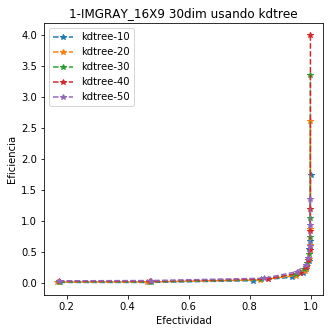

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9 30dim
Tipo: kdtree-10
Tiempo de construcción: 0.40952587127685547
Tiempo de búsqueda: 1.348508596420288
Efeciencia: 0.18027617959957787
Efectividad: 0.9540341619219553
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.01219242202920297


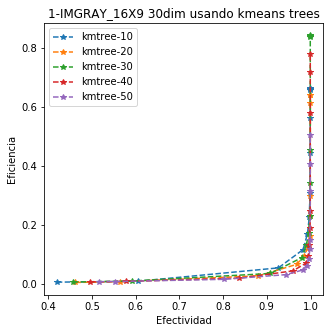

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.796567440032959
Tiempo de búsqueda: 0.34265685081481934
Efeciencia: 0.045808564098946916
Efectividad: 0.9818080822108041
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.002429370417656192


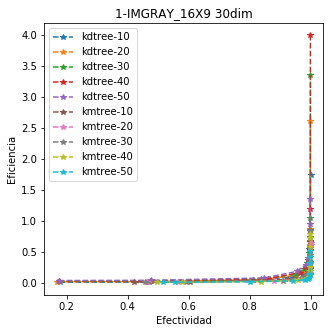

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.796567440032959
Tiempo de búsqueda: 0.34265685081481934
Efeciencia: 0.045808564098946916
Efectividad: 0.9818080822108041
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.002429370417656192


In [340]:
best_configurations.append(show('1-IMGRAY_16X9 30dim', kdtrees_1_30, kmtrees_1_30, 5, 5))

### Dimensión 80

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6854202747344971
Tiempo de búsqueda: 2.3122057914733887
Efeciencia: 0.1334951041353884
Efectividad: 0.9430634634078601
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.010837592854078494


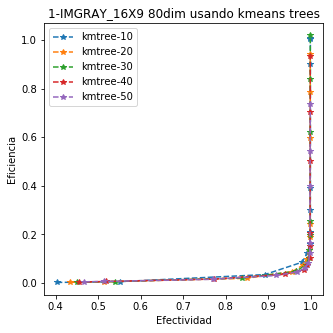

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.092996597290039
Tiempo de búsqueda: 0.7909817695617676
Efeciencia: 0.04566738976427561
Efectividad: 0.9688932092764894
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0030531429169985526


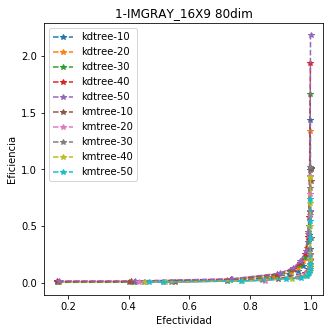

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.092996597290039
Tiempo de búsqueda: 0.7909817695617676
Efeciencia: 0.04566738976427561
Efectividad: 0.9688932092764894
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0030531429169985526


In [341]:
best_configurations.append(show('1-IMGRAY_16X9 80dim', kdtrees_1_80, kmtrees_1_80, 5, 5))

### Dimensión 144

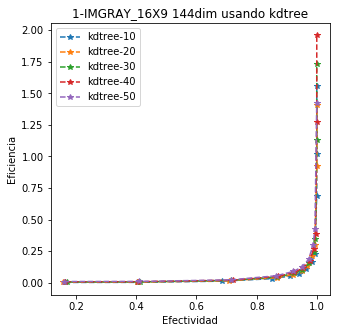

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9 144dim
Tipo: kdtree-10
Tiempo de construcción: 0.9511079788208008
Tiempo de búsqueda: 3.6039435863494873
Efeciencia: 0.12614914554679274
Efectividad: 0.9505624218858492
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.008716810155364045


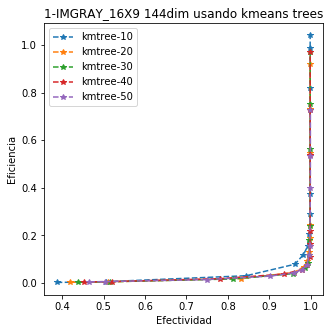

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9 144dim
Tipo: kmtree-30
Tiempo de construcción: 2.8366544246673584
Tiempo de búsqueda: 0.822317361831665
Efeciencia: 0.028783698371054028
Efectividad: 0.9016803221774754
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.0032715972208024373


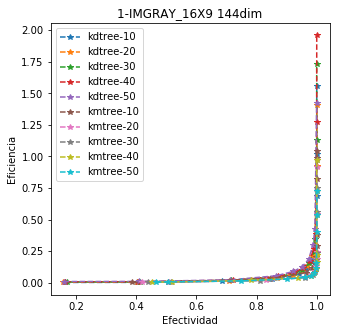

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9 144dim
Tipo: kmtree-30
Tiempo de construcción: 2.8366544246673584
Tiempo de búsqueda: 0.822317361831665
Efeciencia: 0.028783698371054028
Efectividad: 0.9016803221774754
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.0032715972208024373


In [342]:
best_configurations.append(show('1-IMGRAY_16X9 144dim', kdtrees_1_144, kmtrees_1_144, 5, 5))

# Análisis de 1-IMGRAY_16X9_AVG

Se analizará 1-IMGRAY_16x9_AVG al aplicarle diferentes PCA.

In [4]:
dataset_r_2_30 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-30dim-85.3var/R-35798_30_4F.bin", 30)
dataset_q_2_30 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-30dim-85.3var/Q-7201_30_4F.bin", 30)

dataset_r_2_80 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-80dim-96var/R-35798_80_4F.bin", 80)
dataset_q_2_80 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-80dim-96var/Q-7201_80_4F.bin", 80)

dataset_r_2_144 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-144dim-100var/R-35798_144_4F.bin", 144)
dataset_q_2_144 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/PCA-144dim-100var/Q-7201_144_4F.bin", 144)

In [46]:
#Busqueda lineal 30dim
lineal_2_30 = LinearResult()
lineal_2_30.name = "1-IMGRAY_16X9_AVG"
lineal_2_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_2_30, algorithm="linear")
lineal_2_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_2_30, num_neighbors=1, cores=1)
lineal_2_30.search_time = time.time() - t0

lineal_2_30.results_search = results_search
lineal_2_30.dists_search = dists_search

In [47]:
#Busqueda lineal 80dim
lineal_2_80 = LinearResult()
lineal_2_80.name = "1-IMGRAY_16X9_AVG"
lineal_2_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_2_80, algorithm="linear")
lineal_2_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_2_80, num_neighbors=1, cores=1)
lineal_2_80.search_time = time.time() - t0

lineal_2_80.results_search = results_search
lineal_2_80.dists_search = dists_search

In [48]:
#Busqueda lineal 144dim
lineal_2_144 = LinearResult()
lineal_2_144.name = "1-IMGRAY_16X9_AVG"
lineal_2_144.type = "LINEAL 144"

t0 = time.time()
flann.build_index(dataset_r_2_144, algorithm="linear")
lineal_2_144.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_2_144, num_neighbors=1, cores=1)
lineal_2_144.search_time = time.time() - t0

lineal_2_144.results_search = results_search
lineal_2_144.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [49]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_2_30 = get_kdtree_result("1-IMGRAY_16X9_AVG 30dim", "kdtree-10", 10, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [50]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_2_30 = get_kdtree_result("1-IMGRAY_16X9_AVG 30dim", "kdtree-20", 20, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [51]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_2_30 = get_kdtree_result("1-IMGRAY_16X9_AVG 30dim", "kdtree-30", 30, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [52]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_2_30 = get_kdtree_result("1-IMGRAY_16X9_AVG 30dim", "kdtree-40", 40, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [53]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_2_30 = get_kdtree_result("1-IMGRAY_16X9_AVG 30dim", "kdtree-50", 50, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [54]:
kdtrees_2_30 = [kdtree_10_2_30, kdtree_20_2_30, kdtree_30_2_30, kdtree_40_2_30, kdtree_50_2_30]

### Dimension 80

In [55]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_2_80 = get_kdtree_result("1-IMGRAY_16X9_AVG 80dim", "kdtree-10", 10, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [56]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_2_80 = get_kdtree_result("1-IMGRAY_16X9_AVG 80dim", "kdtree-20", 20, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [57]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_2_80 = get_kdtree_result("1-IMGRAY_16X9_AVG 80dim", "kdtree-30", 30, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [58]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_2_80 = get_kdtree_result("1-IMGRAY_16X9_AVG 80dim", "kdtree-40", 40, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [59]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_2_80 = get_kdtree_result("1-IMGRAY_16X9_AVG 80dim", "kdtree-50", 50, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [60]:
kdtrees_2_80 = [kdtree_10_2_80, kdtree_20_2_80, kdtree_30_2_80, kdtree_40_2_80, kdtree_50_2_80]

### Dimension 144

In [61]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_2_144 = get_kdtree_result("1-IMGRAY_16X9_AVG 144dim", "kdtree-10", 10, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [62]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_2_144 = get_kdtree_result("1-IMGRAY_16X9_AVG 144dim", "kdtree-20", 20, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [63]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_2_144 = get_kdtree_result("1-IMGRAY_16X9_AVG 144dim", "kdtree-30", 30, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [64]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_2_144 = get_kdtree_result("1-IMGRAY_16X9_AVG 144dim", "kdtree-40", 40, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [65]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_2_144 = get_kdtree_result("1-IMGRAY_16X9_AVG 144dim", "kdtree-50", 50, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [66]:
kdtrees_2_144 = [kdtree_10_2_144, kdtree_20_2_144, kdtree_30_2_144, kdtree_40_2_144, kdtree_50_2_144]

## Usando K-Means Tree
### Dimensión 30

In [67]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_2_30 = get_kmeans_result("1-IMGRAY_16X9_AVG 30dim", "kmtree-10", 10, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [68]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_2_30 = get_kmeans_result("1-IMGRAY_16X9_AVG 30dim", "kmtree-20", 20, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [69]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_2_30 = get_kmeans_result("1-IMGRAY_16X9_AVG 30dim", "kmtree-30", 30, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [70]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_2_30 = get_kmeans_result("1-IMGRAY_16X9_AVG 30dim", "kmtree-40", 40, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [71]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_2_30 = get_kmeans_result("1-IMGRAY_16X9_AVG 30dim", "kmtree-50", 50, dataset_r_2_30, dataset_q_2_30, lineal_2_30)

In [72]:
kmtrees_2_30 = [kmtree_10_2_30, kmtree_20_2_30, kmtree_30_2_30, kmtree_40_2_30, kmtree_50_2_30]

### Dimensión 80

In [73]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_2_80 = get_kmeans_result("1-IMGRAY_16X9_AVG 80dim", "kmtree-10", 10, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [74]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_2_80 = get_kmeans_result("1-IMGRAY_16X9_AVG 80dim", "kmtree-20", 20, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [75]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_2_80 = get_kmeans_result("1-IMGRAY_16X9_AVG 80dim", "kmtree-30", 30, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [76]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_2_80 = get_kmeans_result("1-IMGRAY_16X9_AVG 80dim", "kmtree-40", 40, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [77]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_2_80 = get_kmeans_result("1-IMGRAY_16X9_AVG 80dim", "kmtree-50", 50, dataset_r_2_80, dataset_q_2_80, lineal_2_80)

In [78]:
kmtrees_2_80 = [kmtree_10_2_80, kmtree_20_2_80, kmtree_30_2_80, kmtree_40_2_80, kmtree_50_2_80]

### Dimensión 144

In [389]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_2_144 = get_kmeans_result("1-IMGRAY_16X9_AVG 144dim", "kmtree-10", 10, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [390]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_2_144 = get_kmeans_result("1-IMGRAY_16X9_AVG 144dim", "kmtree-20", 20, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [391]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_2_144 = get_kmeans_result("1-IMGRAY_16X9_AVG 144dim", "kmtree-30", 30, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [392]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_2_144 = get_kmeans_result("1-IMGRAY_16X9_AVG 144dim", "kmtree-40", 40, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [393]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_2_144 = get_kmeans_result("1-IMGRAY_16X9_AVG 144dim", "kmtree-50", 50, dataset_r_2_144, dataset_q_2_144, lineal_2_144)

In [394]:
kmtrees_2_144 = [kmtree_10_2_144, kmtree_20_2_144, kmtree_30_2_144, kmtree_40_2_144, kmtree_50_2_144]

## Gráficos y resultados
### Dimensión 30

In [343]:
best_configurations.append(show('1-IMGRAY_16X9_AVG 30dim', kdtrees_2_30, kmtrees_2_30, 5, 5))

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9_AVG 30dim
Tipo: kdtree-10
Tiempo de construcción: 0.3653707504272461
Tiempo de búsqueda: 1.3133983612060547
Efeciencia: 0.22793428882188946
Efectividad: 0.9622274684071657
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.015047626783956523


MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9_AVG 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8196439743041992
Tiempo de búsqueda: 0.27394628524780273
Efeciencia: 0.04754247173237052
Efectividad: 0.9569504235522844
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.004113552650750956


MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9_AVG 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8196439743041992
Tiempo de búsqueda: 0.27394628524780273
Efeciencia: 0.04754247173237052
Efectividad: 0.9569504235522844
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.004113552650750956


### Dimensión 80

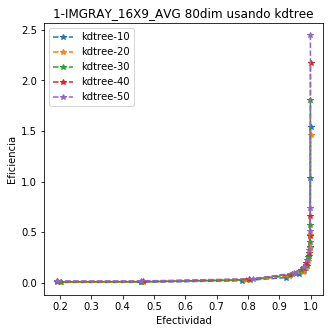

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9_AVG 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6803572177886963
Tiempo de búsqueda: 2.304431915283203
Efeciencia: 0.15527005297158367
Efectividad: 0.978891820580475
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.008415481049037074


MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9_AVG 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.1056504249572754
Tiempo de búsqueda: 0.5656840801239014
Efeciencia: 0.038115215580012865
Efectividad: 0.9615331203999444
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.002932470484876027


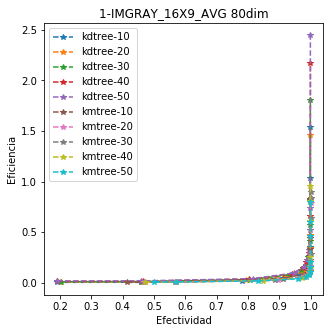

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9_AVG 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.1056504249572754
Tiempo de búsqueda: 0.5656840801239014
Efeciencia: 0.038115215580012865
Efectividad: 0.9615331203999444
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.002932470484876027


In [344]:
best_configurations.append(show('1-IMGRAY_16X9_AVG 80dim', kdtrees_2_80, kmtrees_2_80, 5, 5))

### Dimensión 144

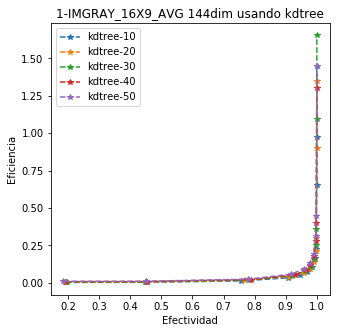

MEJOR KDTREE
Nombre: 1-IMGRAY_16X9_AVG 144dim
Tipo: kdtree-10
Tiempo de construcción: 0.9372162818908691
Tiempo de búsqueda: 2.547496795654297
Efeciencia: 0.09323278374060157
Efectividad: 0.9587557283710596
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.005582218813223986


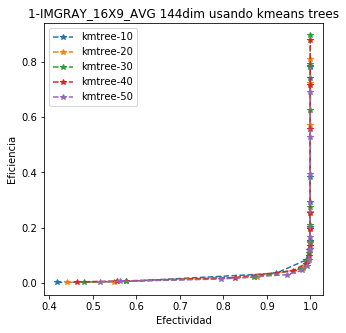

MEJOR KMEANS TREE
Nombre: 1-IMGRAY_16X9 144dim
Tipo: kmtree-50
Tiempo de construcción: 3.811460494995117
Tiempo de búsqueda: 1.2467279434204102
Efeciencia: 0.0456276301645986
Efectividad: 0.9806971253992501
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0024544816022896623


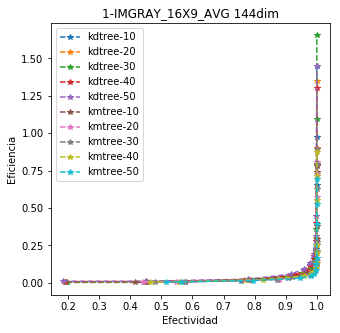

MEJOR CONFIGURACION
Nombre: 1-IMGRAY_16X9 144dim
Tipo: kmtree-50
Tiempo de construcción: 3.811460494995117
Tiempo de búsqueda: 1.2467279434204102
Efeciencia: 0.0456276301645986
Efectividad: 0.9806971253992501
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0024544816022896623


In [345]:
best_configurations.append(show('1-IMGRAY_16X9_AVG 144dim', kdtrees_2_144, kmtrees_2_144, 5, 5))

# Análisis de 2-MEL_16000_80_64_32

Se analizará 2-MEL_16000_80_64_32 al aplicarle diferentes PCA.

In [5]:
dataset_r_3_30 = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/PCA-30dim-92.2var/R-35798_30_4F.bin", 30)
dataset_q_3_30 = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/PCA-30dim-92.2var/Q-7201_30_4F.bin", 30)

dataset_r_3_80 = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/PCA-80dim-100var/R-35798_80_4F.bin", 80)
dataset_q_3_80 = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/PCA-80dim-100var/Q-7201_80_4F.bin", 80)

In [89]:
#Busqueda lineal 30dim
lineal_3_30 = LinearResult()
lineal_3_30.name = "2-MEL_16000_80_64_32"
lineal_3_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_3_30, algorithm="linear")
lineal_3_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_3_30, num_neighbors=1, cores=1)
lineal_3_30.search_time = time.time() - t0

lineal_3_30.results_search = results_search
lineal_3_30.dists_search = dists_search

In [90]:
#Busqueda lineal 80dim
lineal_3_80 = LinearResult()
lineal_3_80.name = "2-MEL_16000_80_64_32"
lineal_3_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_3_80, algorithm="linear")
lineal_3_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_3_80, num_neighbors=1, cores=1)
lineal_3_80.search_time = time.time() - t0

lineal_3_80.results_search = results_search
lineal_3_80.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [91]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_3_30 = get_kdtree_result("2-MEL_16000_80_64_32 30dim", "kdtree-10", 10, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [92]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_3_30 = get_kdtree_result("2-MEL_16000_80_64_32 30dim", "kdtree-20", 20, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [93]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_3_30 = get_kdtree_result("2-MEL_16000_80_64_32 30dim", "kdtree-30", 30, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [94]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_3_30 = get_kdtree_result("2-MEL_16000_80_64_32 30dim", "kdtree-40", 40, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [95]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_3_30 = get_kdtree_result("2-MEL_16000_80_64_32 30dim", "kdtree-50", 50, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [96]:
kdtrees_3_30 = [kdtree_10_3_30, kdtree_20_3_30, kdtree_30_3_30, kdtree_40_3_30, kdtree_50_3_30]

### Dimension 80

In [97]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_3_80 = get_kdtree_result("2-MEL_16000_80_64_32 80dim", "kdtree-10", 10, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [98]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_3_80 = get_kdtree_result("2-MEL_16000_80_64_32 80dim", "kdtree-20", 20, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [99]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_3_80 = get_kdtree_result("2-MEL_16000_80_64_32 80dim", "kdtree-30", 30, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [100]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_3_80 = get_kdtree_result("2-MEL_16000_80_64_32 80dim", "kdtree-40", 40, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [101]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_3_80 = get_kdtree_result("2-MEL_16000_80_64_32 80dim", "kdtree-50", 50, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [102]:
kdtrees_3_80 = [kdtree_10_3_80, kdtree_20_3_80, kdtree_30_3_80, kdtree_40_3_80, kdtree_50_3_80]

## Usando K-Means Tree
### Dimensión 30

In [103]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_3_30 = get_kmeans_result("2-MEL_16000_80_64_32 30dim", "kmtree-10", 10, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [104]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_3_30 = get_kmeans_result("2-MEL_16000_80_64_32 30dim", "kmtree-20", 20, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [105]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_3_30 = get_kmeans_result("2-MEL_16000_80_64_32 30dim", "kmtree-30", 30, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [106]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_3_30 = get_kmeans_result("2-MEL_16000_80_64_32 30dim", "kmtree-40", 40, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [107]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_3_30 = get_kmeans_result("2-MEL_16000_80_64_32 30dim", "kmtree-50", 50, dataset_r_3_30, dataset_q_3_30, lineal_3_30)

In [108]:
kmtrees_3_30 = [kmtree_10_3_30, kmtree_20_3_30, kmtree_30_3_30, kmtree_40_3_30, kmtree_50_3_30]

### Dimensión 80

In [109]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_3_80 = get_kmeans_result("2-MEL_16000_80_64_32 80dim", "kmtree-10", 10, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [110]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_3_80 = get_kmeans_result("2-MEL_16000_80_64_32 80dim", "kmtree-20", 20, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [111]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_3_80 = get_kmeans_result("2-MEL_16000_80_64_32 80dim", "kmtree-30", 30, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [112]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_3_80 = get_kmeans_result("2-MEL_16000_80_64_32 80dim", "kmtree-40", 40, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [113]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_3_80 = get_kmeans_result("2-MEL_16000_80_64_32 80dim", "kmtree-50", 50, dataset_r_3_80, dataset_q_3_80, lineal_3_80)

In [114]:
kmtrees_3_80 = [kmtree_10_3_80, kmtree_20_3_80, kmtree_30_3_80, kmtree_40_3_80, kmtree_50_3_80]

## Gráficos y resultados
### Dimensión 30

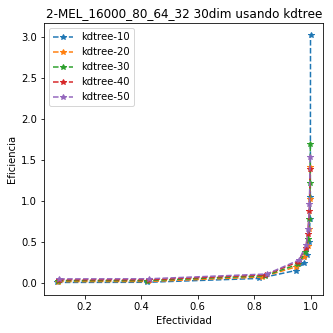

MEJOR KDTREE
Nombre: 2-MEL_16000_80_64_32 30dim
Tipo: kdtree-10
Tiempo de construcción: 0.34954833984375
Tiempo de búsqueda: 1.616687536239624
Efeciencia: 0.2844512498740482
Efectividad: 0.9593112067768366
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.02701465475621839


MEJOR KMEANS TREE
Nombre: 2-MEL_16000_80_64_32 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8064229488372803
Tiempo de búsqueda: 0.5315001010894775
Efeciencia: 0.09351597975072407
Efectividad: 0.9476461602555201
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.01148616300472852


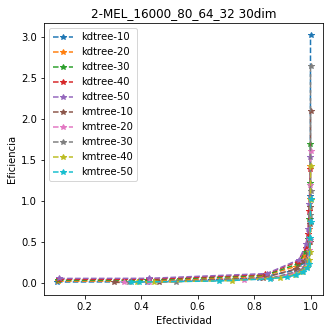

MEJOR CONFIGURACION
Nombre: 2-MEL_16000_80_64_32 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8064229488372803
Tiempo de búsqueda: 0.5315001010894775
Efeciencia: 0.09351597975072407
Efectividad: 0.9476461602555201
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.01148616300472852


In [346]:
best_configurations.append(show('2-MEL_16000_80_64_32 30dim', kdtrees_3_30, kmtrees_3_30, 5, 5))

### Dimensión 80

MEJOR KDTREE
Nombre: 2-MEL_16000_80_64_32 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6369690895080566
Tiempo de búsqueda: 1.7385315895080566
Efeciencia: 0.11730126766413178
Efectividad: 0.9387585057630885
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.012370893453195605


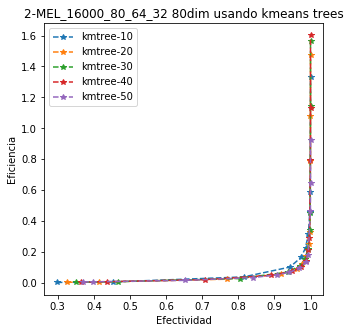

MEJOR KMEANS TREE
Nombre: 2-MEL_16000_80_64_32 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0135486125946045
Tiempo de búsqueda: 1.0195775032043457
Efeciencia: 0.06879243108800649
Efectividad: 0.9415358977919733
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.00815044982198871


MEJOR CONFIGURACION
Nombre: 2-MEL_16000_80_64_32 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0135486125946045
Tiempo de búsqueda: 1.0195775032043457
Efeciencia: 0.06879243108800649
Efectividad: 0.9415358977919733
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.00815044982198871


In [347]:
best_configurations.append(show('2-MEL_16000_80_64_32 80dim', kdtrees_3_80, kmtrees_3_80, 5, 5))

# Análisis de 3-ALEXNET_FC7

Se analizará 3-ALEXNET_FC7 al aplicarle diferentes PCA.

In [6]:
dataset_r_4_30 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-30dim-48.4var/R-35798_30_4F.bin", 30)
dataset_q_4_30 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-30dim-48.4var/Q-7201_30_4F.bin", 30)

dataset_r_4_80 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-80dim-63.5var/R-35798_80_4F.bin", 80)
dataset_q_4_80 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-80dim-63.5var/Q-7201_80_4F.bin", 80)

dataset_r_4_144 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-144dim-71.2var/R-35798_144_4F.bin", 144)
dataset_q_4_144 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-144dim-71.2var/Q-7201_144_4F.bin", 144)

dataset_r_4_400 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-400dim-82.9var/R-35798_400_4F.bin", 400)
dataset_q_4_400 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/PCA-400dim-82.9var/Q-7201_400_4F.bin", 400)

In [119]:
#Busqueda lineal 30dim
lineal_4_30 = LinearResult()
lineal_4_30.name = "3-ALEXNET_FC7"
lineal_4_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_4_30, algorithm="linear")
lineal_4_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_4_30, num_neighbors=1, cores=1)
lineal_4_30.search_time = time.time() - t0

lineal_4_30.results_search = results_search
lineal_4_30.dists_search = dists_search

In [120]:
#Busqueda lineal 80dim
lineal_4_80 = LinearResult()
lineal_4_80.name = "3-ALEXNET_FC7"
lineal_4_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_4_80, algorithm="linear")
lineal_4_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_4_80, num_neighbors=1, cores=1)
lineal_4_80.search_time = time.time() - t0

lineal_4_80.results_search = results_search
lineal_4_80.dists_search = dists_search

In [121]:
#Busqueda lineal 144dim
lineal_4_144 = LinearResult()
lineal_4_144.name = "3-ALEXNET_FC7"
lineal_4_144.type = "LINEAL 144"

t0 = time.time()
flann.build_index(dataset_r_4_144, algorithm="linear")
lineal_4_144.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_4_144, num_neighbors=1, cores=1)
lineal_4_144.search_time = time.time() - t0

lineal_4_144.results_search = results_search
lineal_4_144.dists_search = dists_search

In [122]:
#Busqueda lineal 400dim
lineal_4_400 = LinearResult()
lineal_4_400.name = "3-ALEXNET_FC7"
lineal_4_400.type = "LINEAL 400"

t0 = time.time()
flann.build_index(dataset_r_4_400, algorithm="linear")
lineal_4_400.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_4_400, num_neighbors=1, cores=1)
lineal_4_400.search_time = time.time() - t0

lineal_4_400.results_search = results_search
lineal_4_400.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [123]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_4_30 = get_kdtree_result("3-ALEXNET_FC7 30dim", "kdtree-10", 10, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [124]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_4_30 = get_kdtree_result("3-ALEXNET_FC7 30dim", "kdtree-20", 20, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [125]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_4_30 = get_kdtree_result("3-ALEXNET_FC7 30dim", "kdtree-30", 30, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [126]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_4_30 = get_kdtree_result("3-ALEXNET_FC7 30dim", "kdtree-40", 40, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [127]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_4_30 = get_kdtree_result("3-ALEXNET_FC7 30dim", "kdtree-50", 50, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [128]:
kdtrees_4_30 = [kdtree_10_4_30, kdtree_20_4_30, kdtree_30_4_30, kdtree_40_4_30, kdtree_50_4_30]

### Dimension 80

In [129]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_4_80 = get_kdtree_result("3-ALEXNET_FC7 80dim", "kdtree-10", 10, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [130]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_4_80 = get_kdtree_result("3-ALEXNET_FC7G 80dim", "kdtree-20", 20, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [131]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_4_80 = get_kdtree_result("3-ALEXNET_FC7 80dim", "kdtree-30", 30, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [132]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_4_80 = get_kdtree_result("3-ALEXNET_FC7 80dim", "kdtree-40", 40, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [133]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_4_80 = get_kdtree_result("3-ALEXNET_FC7 80dim", "kdtree-50", 50, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [134]:
kdtrees_4_80 = [kdtree_10_4_80, kdtree_20_4_80, kdtree_30_4_80, kdtree_40_4_80, kdtree_50_4_80]

### Dimension 144

In [135]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_4_144 = get_kdtree_result("3-ALEXNET_FC7 144dim", "kdtree-10", 10, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [136]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_4_144 = get_kdtree_result("3-ALEXNET_FC7 144dim", "kdtree-20", 20, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [137]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_4_144 = get_kdtree_result("3-ALEXNET_FC7 144dim", "kdtree-30", 30, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [138]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_4_144 = get_kdtree_result("3-ALEXNET_FC7 144dim", "kdtree-40", 40, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [139]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_4_144 = get_kdtree_result("3-ALEXNET_FC7 144dim", "kdtree-50", 50, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [140]:
kdtrees_4_144 = [kdtree_10_4_144, kdtree_20_4_144, kdtree_30_4_144, kdtree_40_4_144, kdtree_50_4_144]

### Dimension 400

In [141]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_4_400 = get_kdtree_result("3-ALEXNET_FC7 400dim", "kdtree-10", 10, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [142]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_4_400 = get_kdtree_result("3-ALEXNET_FC7 400dim", "kdtree-20", 20, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [143]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_4_400 = get_kdtree_result("3-ALEXNET_FC7 400dim", "kdtree-30", 30, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [144]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_4_400 = get_kdtree_result("3-ALEXNET_FC7 400dim", "kdtree-40", 40, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [145]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_4_400 = get_kdtree_result("3-ALEXNET_FC7 400dim", "kdtree-50", 50, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [146]:
kdtrees_4_400 = [kdtree_10_4_400, kdtree_20_4_400, kdtree_30_4_400, kdtree_40_4_400, kdtree_50_4_400]

## Usando K-Means Tree
### Dimensión 30

In [147]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_4_30 = get_kmeans_result("3-ALEXNET_FC7 30dim", "kmtree-10", 10, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [148]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_4_30 = get_kmeans_result("3-ALEXNET_FC7 30dim", "kmtree-20", 20, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [149]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_4_30 = get_kmeans_result("3-ALEXNET_FC7 30dim", "kmtree-30", 30, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [150]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_4_30 = get_kmeans_result("3-ALEXNET_FC7 30dim", "kmtree-40", 40, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [151]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_4_30 = get_kmeans_result("3-ALEXNET_FC7 30dim", "kmtree-50", 50, dataset_r_4_30, dataset_q_4_30, lineal_4_30)

In [152]:
kmtrees_4_30 = [kmtree_10_4_30, kmtree_20_4_30, kmtree_30_4_30, kmtree_40_4_30, kmtree_50_4_30]

### Dimensión 80

In [153]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_4_80 = get_kmeans_result("3-ALEXNET_FC7 80dim", "kmtree-10", 10, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [154]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_4_80 = get_kmeans_result("3-ALEXNET_FC7 80dim", "kmtree-20", 20, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [155]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_4_80 = get_kmeans_result("3-ALEXNET_FC7 80dim", "kmtree-30", 30, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [156]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_4_80 = get_kmeans_result("3-ALEXNET_FC7 80dim", "kmtree-40", 40, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [157]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_4_80 = get_kmeans_result("3-ALEXNET_FC7 80dim", "kmtree-50", 50, dataset_r_4_80, dataset_q_4_80, lineal_4_80)

In [158]:
kmtrees_4_80 = [kmtree_10_4_80, kmtree_20_4_80, kmtree_30_4_80, kmtree_40_4_80, kmtree_50_4_80]

### Dimensión 144

In [159]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_4_144 = get_kmeans_result("3-ALEXNET_FC7 144dim", "kmtree-10", 10, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [160]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_4_144 = get_kmeans_result("3-ALEXNET_FC7 144dim", "kmtree-20", 20, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [161]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_4_144 = get_kmeans_result("3-ALEXNET_FC7 144dim", "kmtree-30", 30, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [162]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_4_144 = get_kmeans_result("3-ALEXNET_FC7 144dim", "kmtree-40", 40, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [163]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_4_144 = get_kmeans_result("3-ALEXNET_FC7 144dim", "kmtree-50", 50, dataset_r_4_144, dataset_q_4_144, lineal_4_144)

In [164]:
kmtrees_4_144 = [kmtree_10_4_144, kmtree_20_4_144, kmtree_30_4_144, kmtree_40_4_144, kmtree_50_4_144]

### Dimension 400

In [167]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kmtree_10_4_400 = get_kmeans_result("3-ALEXNET_FC7 400dim", "kmtree-10", 10, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [168]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kmtree_20_4_400 = get_kmeans_result("3-ALEXNET_FC7 400dim", "kmtree-20", 20, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [169]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kmtree_30_4_400 = get_kmeans_result("3-ALEXNET_FC7 400dim", "kmtree-30", 30, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [170]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kmtree_40_4_400 = get_kmeans_result("3-ALEXNET_FC7 400dim", "kmtree-40", 40, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [171]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kmtree_50_4_400 = get_kmeans_result("3-ALEXNET_FC7 400dim", "kmtree-50", 50, dataset_r_4_400, dataset_q_4_400, lineal_4_400)

In [172]:
kmtrees_4_400 = [kmtree_10_4_400, kmtree_20_4_400, kmtree_30_4_400, kmtree_40_4_400, kmtree_50_4_400]

## Gráficos y resultados
### Dimensión 30

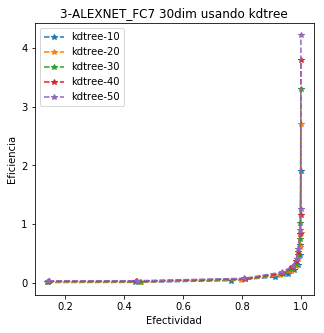

MEJOR KDTREE
Nombre: 3-ALEXNET_FC7 30dim
Tipo: kdtree-10
Tiempo de construcción: 0.3649775981903076
Tiempo de búsqueda: 1.3623740673065186
Efeciencia: 0.18326218112597928
Efectividad: 0.9363977225385363
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.017734701843250843


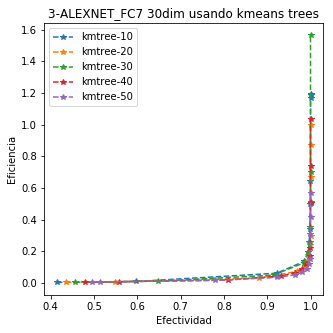

MEJOR KMEANS TREE
Nombre: 3-ALEXNET_FC7 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.796389102935791
Tiempo de búsqueda: 0.37964582443237305
Efeciencia: 0.05106891232983716
Efectividad: 0.9644493820302735
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.003871880244582033


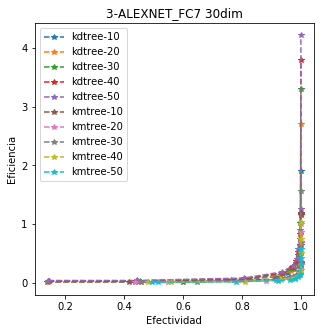

MEJOR CONFIGURACION
Nombre: 3-ALEXNET_FC7 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.796389102935791
Tiempo de búsqueda: 0.37964582443237305
Efeciencia: 0.05106891232983716
Efectividad: 0.9644493820302735
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.003871880244582033


In [348]:
best_configurations.append(show('3-ALEXNET_FC7 30dim', kdtrees_4_30, kmtrees_4_30, 5, 5))

### Dimensión 80

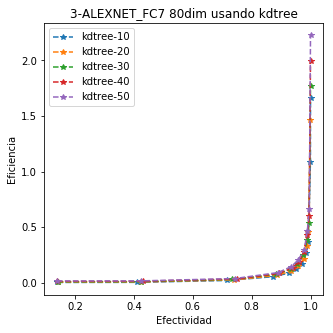

MEJOR KDTREE
Nombre: 3-ALEXNET_FC7 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6535491943359375
Tiempo de búsqueda: 2.3341665267944336
Efeciencia: 0.14667553971860575
Efectividad: 0.9347312873212054
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.013014777661729891


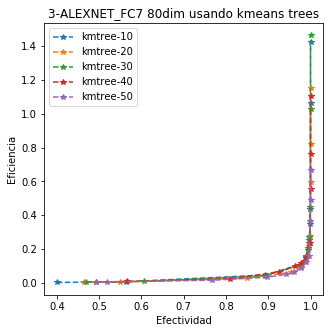

MEJOR KMEANS TREE
Nombre: 3-ALEXNET_FC7 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0018699169158936
Tiempo de búsqueda: 1.0357611179351807
Efeciencia: 0.06508570570838984
Efectividad: 0.9615331203999444
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.005715849913724301


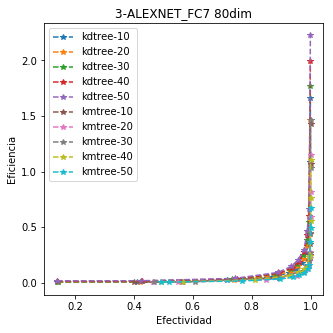

MEJOR CONFIGURACION
Nombre: 3-ALEXNET_FC7 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0018699169158936
Tiempo de búsqueda: 1.0357611179351807
Efeciencia: 0.06508570570838984
Efectividad: 0.9615331203999444
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.005715849913724301


In [349]:
best_configurations.append(show('3-ALEXNET_FC7 80dim', kdtrees_4_80, kmtrees_4_80, 5, 5))

### Dimensión 144

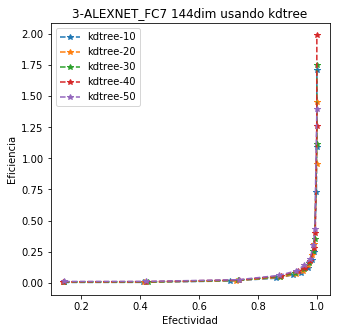

MEJOR KDTREE
Nombre: 3-ALEXNET_FC7 144dim
Tipo: kdtree-10
Tiempo de construcción: 0.9191067218780518
Tiempo de búsqueda: 3.8310186862945557
Efeciencia: 0.13934658341959136
Efectividad: 0.9568115539508402
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.009615293915954747


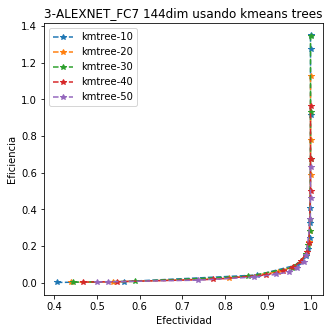

MEJOR KMEANS TREE
Nombre: 3-ALEXNET_FC7 144dim
Tipo: kmtree-50
Tiempo de construcción: 3.6605827808380127
Tiempo de búsqueda: 1.6505722999572754
Efeciencia: 0.06003670359342089
Efectividad: 0.9498680738786279
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.006117615795002985


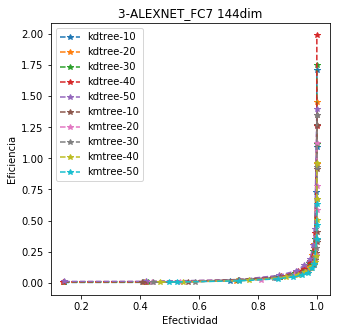

MEJOR CONFIGURACION
Nombre: 3-ALEXNET_FC7 144dim
Tipo: kmtree-50
Tiempo de construcción: 3.6605827808380127
Tiempo de búsqueda: 1.6505722999572754
Efeciencia: 0.06003670359342089
Efectividad: 0.9498680738786279
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.006117615795002985


In [350]:
best_configurations.append(show('3-ALEXNET_FC7 144dim', kdtrees_4_144, kmtrees_4_144, 5, 5))

### Dimensión 400

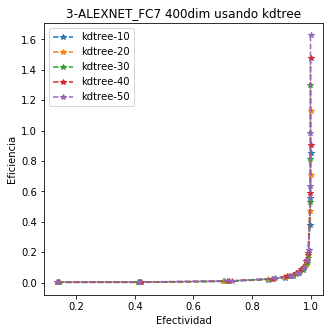

MEJOR KDTREE
Nombre: 3-ALEXNET_FC7 400dim
Tipo: kdtree-10
Tiempo de construcción: 1.9916050434112549
Tiempo de búsqueda: 4.776373863220215
Efeciencia: 0.06364734508479826
Efectividad: 0.9575059019580614
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.005425504181175829


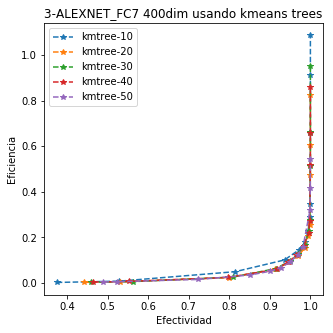

MEJOR KMEANS TREE
Nombre: 3-ALEXNET_FC7 400dim
Tipo: kmtree-50
Tiempo de construcción: 9.837461709976196
Tiempo de búsqueda: 5.010239124298096
Efeciencia: 0.06676370770111434
Efectividad: 0.926537980835995
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.009854060925652467


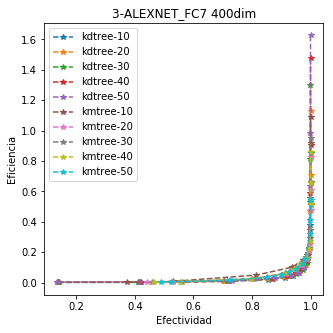

MEJOR CONFIGURACION
Nombre: 3-ALEXNET_FC7 400dim
Tipo: kdtree-10
Tiempo de construcción: 1.9916050434112549
Tiempo de búsqueda: 4.776373863220215
Efeciencia: 0.06364734508479826
Efectividad: 0.9575059019580614
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.005425504181175829


In [351]:
best_configurations.append(show('3-ALEXNET_FC7 400dim', kdtrees_4_400, kmtrees_4_400, 5, 5))

# Análisis de 3-VGG_FC7

Se analizará 3-VGG_FC7 al aplicarle diferentes PCA.

In [7]:
dataset_r_5_30 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-30dim-58.1var/R-35798_30_4F.bin", 30)
dataset_q_5_30 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-30dim-58.1var/Q-7201_30_4F.bin", 30)

dataset_r_5_80 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-80dim-74.2var/R-35798_80_4F.bin", 80)
dataset_q_5_80 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-80dim-74.2var/Q-7201_80_4F.bin", 80)

dataset_r_5_144 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-144dim-81.2var/R-35798_144_4F.bin", 144)
dataset_q_5_144 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-144dim-81.2var/Q-7201_144_4F.bin", 144)

dataset_r_5_400 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-400dim-89.6var/R-35798_400_4F.bin", 400)
dataset_q_5_400 = load_file(carpeta_descriptores+"3-VGG_FC7/PCA-400dim-89.6var/Q-7201_400_4F.bin", 400)

In [181]:
#Busqueda lineal 30dim
lineal_5_30 = LinearResult()
lineal_5_30.name = "3-VGG_FC7"
lineal_5_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_5_30, algorithm="linear")
lineal_5_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_5_30, num_neighbors=1, cores=1)
lineal_5_30.search_time = time.time() - t0

lineal_5_30.results_search = results_search
lineal_5_30.dists_search = dists_search

In [182]:
#Busqueda lineal 80dim
lineal_5_80 = LinearResult()
lineal_5_80.name = "3-VGG_FC7"
lineal_5_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_5_80, algorithm="linear")
lineal_5_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_5_80, num_neighbors=1, cores=1)
lineal_5_80.search_time = time.time() - t0

lineal_5_80.results_search = results_search
lineal_5_80.dists_search = dists_search

In [183]:
#Busqueda lineal 144dim
lineal_5_144 = LinearResult()
lineal_5_144.name = "3-VGG_FC7"
lineal_5_144.type = "LINEAL 144"

t0 = time.time()
flann.build_index(dataset_r_5_144, algorithm="linear")
lineal_5_144.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_5_144, num_neighbors=1, cores=1)
lineal_5_144.search_time = time.time() - t0

lineal_5_144.results_search = results_search
lineal_5_144.dists_search = dists_search

In [184]:
#Busqueda lineal 400dim
lineal_5_400 = LinearResult()
lineal_5_400.name = "3-VGG_FC7"
lineal_5_400.type = "LINEAL 400"

t0 = time.time()
flann.build_index(dataset_r_5_400, algorithm="linear")
lineal_5_400.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_5_400, num_neighbors=1, cores=1)
lineal_5_400.search_time = time.time() - t0

lineal_5_400.results_search = results_search
lineal_5_400.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [185]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_5_30 = get_kdtree_result("3-VGG_FC7 30dim", "kdtree-10", 10, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [186]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_5_30 = get_kdtree_result("3-VGG_FC7 30dim", "kdtree-20", 20, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [187]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_5_30 = get_kdtree_result("3-VGG_FC7 30dim", "kdtree-30", 30, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [188]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_5_30 = get_kdtree_result("3-VGG_FC7 30dim", "kdtree-40", 40, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [189]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_5_30 = get_kdtree_result("3-VGG_FC7 30dim", "kdtree-50", 50, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [190]:
kdtrees_5_30 = [kdtree_10_5_30, kdtree_20_5_30, kdtree_30_5_30, kdtree_40_5_30, kdtree_50_5_30]

### Dimension 80

In [191]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_5_80 = get_kdtree_result("3-VGG_FC7 80dim", "kdtree-10", 10, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [192]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_5_80 = get_kdtree_result("3-VGG_FC7 80dim", "kdtree-20", 20, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [193]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_5_80 = get_kdtree_result("3-VGG_FC7 80dim", "kdtree-30", 30, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [194]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_5_80 = get_kdtree_result("3-VGG_FC7 80dim", "kdtree-40", 40, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [195]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_5_80 = get_kdtree_result("3-VGG_FC7 80dim", "kdtree-50", 50, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [196]:
kdtrees_5_80 = [kdtree_10_5_80, kdtree_20_5_80, kdtree_30_5_80, kdtree_40_5_80, kdtree_50_5_80]

### Dimension 144

In [197]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_5_144 = get_kdtree_result("3-VGG_FC7 144dim", "kdtree-10", 10, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [198]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_5_144 = get_kdtree_result("3-VGG_FC7 144dim", "kdtree-20", 20, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [199]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_5_144 = get_kdtree_result("3-VGG_FC7 144dim", "kdtree-30", 30, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [200]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_5_144 = get_kdtree_result("3-VGG_FC7 144dim", "kdtree-40", 40, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [201]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_5_144 = get_kdtree_result("3-VGG_FC7 144dim", "kdtree-50", 50, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [202]:
kdtrees_5_144 = [kdtree_10_5_144, kdtree_20_5_144, kdtree_30_5_144, kdtree_40_5_144, kdtree_50_5_144]

### Dimension 400

In [203]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_5_400 = get_kdtree_result("3-VGG_FC7 400dim", "kdtree-10", 10, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [204]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_5_400 = get_kdtree_result("3-VGG_FC7 400dim", "kdtree-20", 20, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [205]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_5_400 = get_kdtree_result("3-VGG_FC7 400dim", "kdtree-30", 30, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [206]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_5_400 = get_kdtree_result("3-VGG_FC7 400dim", "kdtree-40", 40, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [207]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_5_400 = get_kdtree_result("3-VGG_FC7 400dim", "kdtree-50", 50, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [208]:
kdtrees_5_400 = [kdtree_10_5_400, kdtree_20_5_400, kdtree_30_5_400, kdtree_40_5_400, kdtree_50_5_400]

## Usando K-Means Tree
### Dimensión 30

In [209]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_5_30 = get_kmeans_result("3-VGG_FC7 30dim", "kmtree-10", 10, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [210]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_5_30 = get_kmeans_result("3-VGG_FC7 30dim", "kmtree-20", 20, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [211]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_5_30 = get_kmeans_result("3-VGG_FC7 30dim", "kmtree-30", 30, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [212]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_5_30 = get_kmeans_result("3-VGG_FC7 30dim", "kmtree-40", 40, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [213]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_5_30 = get_kmeans_result("3-VGG_FC7 30dim", "kmtree-50", 50, dataset_r_5_30, dataset_q_5_30, lineal_5_30)

In [214]:
kmtrees_5_30 = [kmtree_10_5_30, kmtree_20_5_30, kmtree_30_5_30, kmtree_40_5_30, kmtree_50_5_30]

### Dimensión 80

In [215]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_5_80 = get_kmeans_result("3-VGG_FC7 80dim", "kmtree-10", 10, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [216]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_5_80 = get_kmeans_result("3-VGG_FC7 80dim", "kmtree-20", 20, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [217]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_5_80 = get_kmeans_result("3-VGG_FC7 80dim", "kmtree-30", 30, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [218]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_5_80 = get_kmeans_result("3-VGG_FC7 80dim", "kmtree-40", 40, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [219]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_5_80 = get_kmeans_result("3-VGG_FC7 80dim", "kmtree-50", 50, dataset_r_5_80, dataset_q_5_80, lineal_5_80)

In [220]:
kmtrees_5_80 = [kmtree_10_5_80, kmtree_20_5_80, kmtree_30_5_80, kmtree_40_5_80, kmtree_50_5_80]

### Dimensión 144

In [221]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_5_144 = get_kmeans_result("3-VGG_FC7 144dim", "kmtree-10", 10, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [222]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_5_144 = get_kmeans_result("3-VGG_FC7 144dim", "kmtree-20", 20, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [223]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_5_144 = get_kmeans_result("3-VGG_FC7 144dim", "kmtree-30", 30, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [224]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_5_144 = get_kmeans_result("3-VGG_FC7 144dim", "kmtree-40", 40, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [225]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_5_144 = get_kmeans_result("3-VGG_FC7 144dim", "kmtree-50", 50, dataset_r_5_144, dataset_q_5_144, lineal_5_144)

In [226]:
kmtrees_5_144 = [kmtree_10_5_144, kmtree_20_5_144, kmtree_30_5_144, kmtree_40_5_144, kmtree_50_5_144]

### Dimension 400

In [228]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kmtree_10_5_400 = get_kmeans_result("3-VGG_FC7 400dim", "kmtree-10", 10, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [229]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kmtree_20_5_400 = get_kmeans_result("3-VGG_FC7 400dim", "kmtree-20", 20, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [230]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kmtree_30_5_400 = get_kmeans_result("3-VGG_FC7 400dim", "kmtree-30", 30, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [231]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kmtree_40_5_400 = get_kmeans_result("3-VGG_FC7 400dim", "kmtree-40", 40, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [232]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kmtree_50_5_400 = get_kmeans_result("3-VGG_FC7 400dim", "kmtree-50", 50, dataset_r_5_400, dataset_q_5_400, lineal_5_400)

In [233]:
kmtrees_5_400 = [kmtree_10_5_400, kmtree_20_5_400, kmtree_30_5_400, kmtree_40_5_400, kmtree_50_5_400]

## Gráficos y resultados
### Dimensión 30

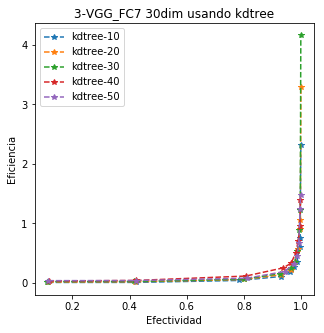

MEJOR KDTREE
Nombre: 3-VGG_FC7 30dim
Tipo: kdtree-10
Tiempo de construcción: 0.387418270111084
Tiempo de búsqueda: 1.455251932144165
Efeciencia: 0.19191805077869714
Efectividad: 0.9427857242049715
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.016715365856981378


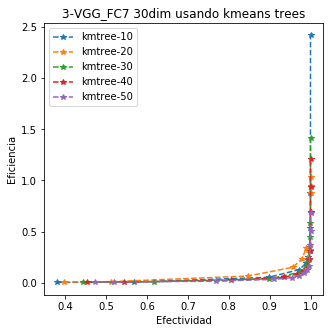

MEJOR KMEANS TREE
Nombre: 3-VGG_FC7 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.7952275276184082
Tiempo de búsqueda: 0.37801289558410645
Efeciencia: 0.04985243247840647
Efectividad: 0.9545896403277323
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004547365789578792


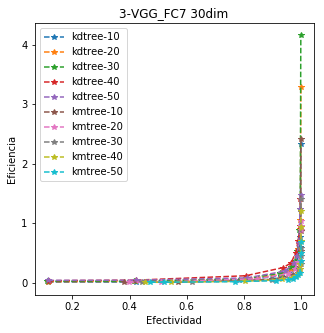

MEJOR CONFIGURACION
Nombre: 3-VGG_FC7 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.7952275276184082
Tiempo de búsqueda: 0.37801289558410645
Efeciencia: 0.04985243247840647
Efectividad: 0.9545896403277323
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004547365789578792


In [352]:
best_configurations.append(show('3-VGG_FC7 30dim', kdtrees_5_30, kmtrees_5_30, 5, 5))

### Dimensión 80

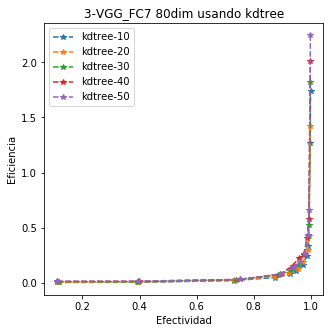

MEJOR KDTREE
Nombre: 3-VGG_FC7 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6982479095458984
Tiempo de búsqueda: 2.850846290588379
Efeciencia: 0.14161623302152554
Efectividad: 0.9408415497847521
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.011124272034442589


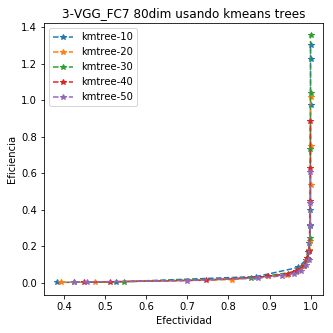

MEJOR KMEANS TREE
Nombre: 3-VGG_FC7 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0136375427246094
Tiempo de búsqueda: 1.007770299911499
Efeciencia: 0.05006119166211107
Efectividad: 0.9587557283710596
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.004207212852832437


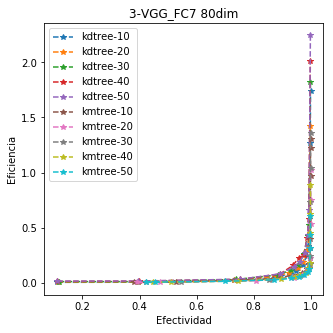

MEJOR CONFIGURACION
Nombre: 3-VGG_FC7 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0136375427246094
Tiempo de búsqueda: 1.007770299911499
Efeciencia: 0.05006119166211107
Efectividad: 0.9587557283710596
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.004207212852832437


In [353]:
best_configurations.append(show('3-VGG_FC7 80dim', kdtrees_5_80, kmtrees_5_80, 5, 5))

### Dimensión 144

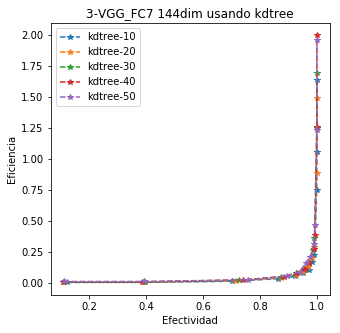

MEJOR KDTREE
Nombre: 3-VGG_FC7 144dim
Tipo: kdtree-10
Tiempo de construcción: 0.9942359924316406
Tiempo de búsqueda: 5.517897844314575
Efeciencia: 0.15530310121942018
Efectividad: 0.9600055547840578
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.008318203064892948


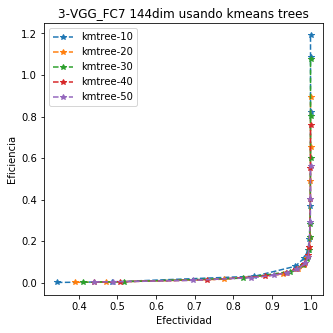

MEJOR KMEANS TREE
Nombre: 3-VGG_FC7 144dim
Tipo: kmtree-20
Tiempo de construcción: 2.139204502105713
Tiempo de búsqueda: 1.2883212566375732
Efeciencia: 0.03626028583671734
Efectividad: 0.9065407582280239
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0053217274774052265


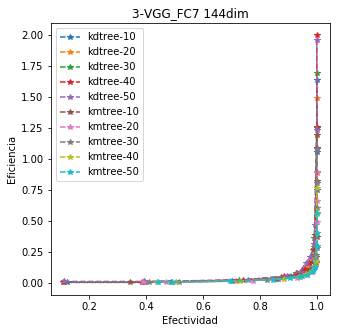

MEJOR CONFIGURACION
Nombre: 3-VGG_FC7 144dim
Tipo: kmtree-20
Tiempo de construcción: 2.139204502105713
Tiempo de búsqueda: 1.2883212566375732
Efeciencia: 0.03626028583671734
Efectividad: 0.9065407582280239
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.0053217274774052265


In [354]:
best_configurations.append(show('3-VGG_FC7 144dim', kdtrees_5_144, kmtrees_5_144, 5, 5))

### Dimensión 400

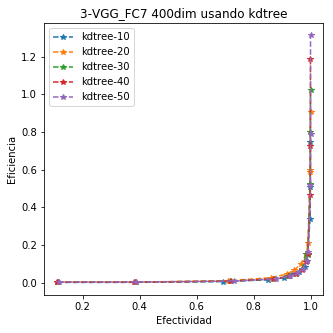

MEJOR KDTREE
Nombre: 3-VGG_FC7 400dim
Tipo: kdtree-30
Tiempo de construcción: 6.887439250946045
Tiempo de búsqueda: 5.226175785064697
Efeciencia: 0.05031834597407264
Efectividad: 0.9520899875017359
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.004356782968399745


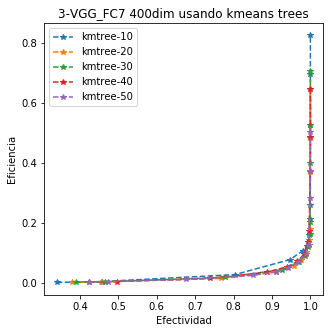

MEJOR KMEANS TREE
Nombre: 3-VGG_FC7 400dim
Tipo: kmtree-20
Tiempo de construcción: 5.8785176277160645
Tiempo de búsqueda: 3.8757376670837402
Efeciencia: 0.03731614393783491
Efectividad: 0.9093181502569088
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004952811408293423


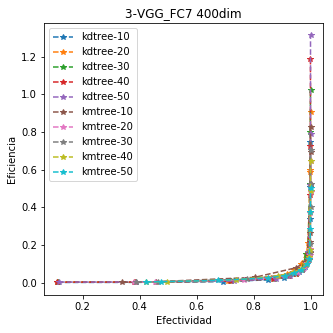

MEJOR CONFIGURACION
Nombre: 3-VGG_FC7 400dim
Tipo: kdtree-30
Tiempo de construcción: 6.887439250946045
Tiempo de búsqueda: 5.226175785064697
Efeciencia: 0.05031834597407264
Efectividad: 0.9520899875017359
Cantidad de checks: 700
Con una distancia euclideana al óptimo de: 0.004356782968399745


In [355]:
best_configurations.append(show('3-VGG_FC7 400dim', kdtrees_5_400, kmtrees_5_400, 5, 5))

# Análisis de 4-SIFT_240_1

Se analizará 4-SIFT_240_1 al aplicarle diferentes PCA.

In [8]:
dataset_r_6_30 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-30dim-82.2var/R-35798_30_4F.bin", 30)
dataset_q_6_30 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-30dim-82.2var/Q-7201_30_4F.bin", 30)

dataset_r_6_64 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-64dim-94.2var/R-35798_64_4F.bin", 64)
dataset_q_6_64 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-64dim-94.2var/Q-7201_64_4F.bin", 64)

dataset_r_6_80 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-80dim-96.7var/R-35798_80_4F.bin", 80)
dataset_q_6_80 = load_file(carpeta_descriptores+"4-SIFT_240_1/PCA-80dim-96.7var/Q-7201_80_4F.bin", 80)

In [240]:
#Busqueda lineal 30dim
lineal_6_30 = LinearResult()
lineal_6_30.name = "4-SIFT_240_1"
lineal_6_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_6_30, algorithm="linear")
lineal_6_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_6_30, num_neighbors=1, cores=1)
lineal_6_30.search_time = time.time() - t0

lineal_6_30.results_search = results_search
lineal_6_30.dists_search = dists_search

In [241]:
#Busqueda lineal 144dim
lineal_6_64 = LinearResult()
lineal_6_64.name = "4-SIFT_240_1"
lineal_6_64.type = "LINEAL 64"

t0 = time.time()
flann.build_index(dataset_r_6_64, algorithm="linear")
lineal_6_64.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_6_64, num_neighbors=1, cores=1)
lineal_6_64.search_time = time.time() - t0

lineal_6_64.results_search = results_search
lineal_6_64.dists_search = dists_search

In [242]:
#Busqueda lineal 80dim
lineal_6_80 = LinearResult()
lineal_6_80.name = "4-SIFT_240_1"
lineal_6_80.type = "LINEAL 80"

t0 = time.time()
flann.build_index(dataset_r_6_80, algorithm="linear")
lineal_6_80.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_6_80, num_neighbors=1, cores=1)
lineal_6_80.search_time = time.time() - t0

lineal_6_80.results_search = results_search
lineal_6_80.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [243]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_6_30 = get_kdtree_result("4-SIFT_240_1 30dim", "kdtree-10", 10, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [244]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_6_30 = get_kdtree_result("4-SIFT_240_1 30dim", "kdtree-20", 20, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [245]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_6_30 = get_kdtree_result("4-SIFT_240_1 30dim", "kdtree-30", 30, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [246]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_6_30 = get_kdtree_result("4-SIFT_240_1 30dim", "kdtree-40", 40, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [247]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_6_30 = get_kdtree_result("4-SIFT_240_1 30dim", "kdtree-50", 50, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [248]:
kdtrees_6_30 = [kdtree_10_6_30, kdtree_20_6_30, kdtree_30_6_30, kdtree_40_6_30, kdtree_50_6_30]

### Dimension 64

In [249]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_6_64 = get_kdtree_result("4-SIFT_240_1 64dim", "kdtree-10", 10, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [250]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_6_64 = get_kdtree_result("4-SIFT_240_1 64dim", "kdtree-20", 20, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [251]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_6_64 = get_kdtree_result("4-SIFT_240_1 64dim", "kdtree-30", 30, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [252]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_6_64 = get_kdtree_result("4-SIFT_240_1 64dim", "kdtree-40", 40, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [253]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_6_64 = get_kdtree_result("4-SIFT_240_1 64dim", "kdtree-50", 50, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [254]:
kdtrees_6_64 = [kdtree_10_6_64, kdtree_20_6_64, kdtree_30_6_64, kdtree_40_6_64, kdtree_50_6_64]

### Dimension 80

In [255]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_6_80 = get_kdtree_result("4-SIFT_240_1 80dim", "kdtree-10", 10, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [256]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_6_80 = get_kdtree_result("4-SIFT_240_1 80dim", "kdtree-20", 20, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [257]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_6_80 = get_kdtree_result("4-SIFT_240_1 80dim", "kdtree-30", 30, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [258]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_6_80 = get_kdtree_result("4-SIFT_240_1 80dim", "kdtree-40", 40, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [259]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_6_80 = get_kdtree_result("4-SIFT_240_1 80dim", "kdtree-50", 50, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [260]:
kdtrees_6_80 = [kdtree_10_6_80, kdtree_20_6_80, kdtree_30_6_80, kdtree_40_6_80, kdtree_50_6_80]

## Usando K-Means Tree
### Dimensión 30

In [261]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_6_30 = get_kmeans_result("4-SIFT_240_1 30dim", "kmtree-10", 10, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [262]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_6_30 = get_kmeans_result("4-SIFT_240_1 30dim", "kmtree-20", 20, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [263]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_6_30 = get_kmeans_result("4-SIFT_240_1 30dim", "kmtree-30", 30, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [264]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_6_30 = get_kmeans_result("4-SIFT_240_1 30dim", "kmtree-40", 40, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [265]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_6_30 = get_kmeans_result("4-SIFT_240_1 30dim", "kmtree-50", 50, dataset_r_6_30, dataset_q_6_30, lineal_6_30)

In [266]:
kmtrees_6_30 = [kmtree_10_6_30, kmtree_20_6_30, kmtree_30_6_30, kmtree_40_6_30, kmtree_50_6_30]

### Dimensión 64

In [267]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_6_64 = get_kmeans_result("4-SIFT_240_1 64dim", "kmtree-10", 10, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [268]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_6_64 = get_kmeans_result("4-SIFT_240_1 64dim", "kmtree-20", 20, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [269]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_6_64 = get_kmeans_result("4-SIFT_240_1 64dim", "kmtree-30", 30, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [270]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_6_64 = get_kmeans_result("4-SIFT_240_1 64dim", "kmtree-40", 40, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [271]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_6_64 = get_kmeans_result("4-SIFT_240_1 64dim", "kmtree-50", 50, dataset_r_6_64, dataset_q_6_64, lineal_6_64)

In [272]:
kmtrees_6_64 = [kmtree_10_6_64, kmtree_20_6_64, kmtree_30_6_64, kmtree_40_6_64, kmtree_50_6_64]

### Dimensión 80

In [273]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_6_80 = get_kmeans_result("4-SIFT_240_1 80dim", "kmtree-10", 10, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [274]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_6_80 = get_kmeans_result("4-SIFT_240_1 80dim", "kmtree-20", 20, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [275]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_6_80 = get_kmeans_result("4-SIFT_240_1 80dim", "kmtree-30", 30, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [276]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_6_80 = get_kmeans_result("4-SIFT_240_1 80dim", "kmtree-40", 40, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [277]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_6_80 = get_kmeans_result("4-SIFT_240_1 80dim", "kmtree-50", 50, dataset_r_6_80, dataset_q_6_80, lineal_6_80)

In [278]:
kmtrees_6_80 = [kmtree_10_6_80, kmtree_20_6_80, kmtree_30_6_80, kmtree_40_6_80, kmtree_50_6_80]

## Gráficos y resultados
### Dimensión 30

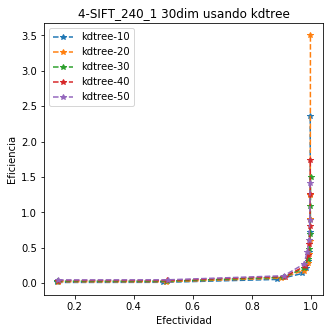

MEJOR KDTREE
Nombre: 4-SIFT_240_1 30dim
Tipo: kdtree-20
Tiempo de construcción: 0.7302441596984863
Tiempo de búsqueda: 0.6875407695770264
Efeciencia: 0.10340191820000923
Efectividad: 0.9089015414525761
Cantidad de checks: 100
Con una distancia euclideana al óptimo de: 0.01490656980920505


MEJOR KMEANS TREE
Nombre: 4-SIFT_240_1 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8046982288360596
Tiempo de búsqueda: 0.40283823013305664
Efeciencia: 0.060584490133585266
Efectividad: 0.9706985140952645
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004529057520971901


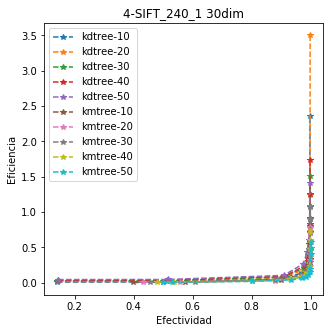

MEJOR CONFIGURACION
Nombre: 4-SIFT_240_1 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.8046982288360596
Tiempo de búsqueda: 0.40283823013305664
Efeciencia: 0.060584490133585266
Efectividad: 0.9706985140952645
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004529057520971901


In [356]:
best_configurations.append(show('4-SIFT_240_1 30dim', kdtrees_6_30, kmtrees_6_30, 5, 5))

### Dimensión 64

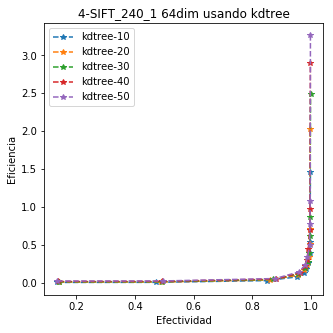

MEJOR KDTREE
Nombre: 4-SIFT_240_1 64dim
Tipo: kdtree-10
Tiempo de construcción: 0.5925209522247314
Tiempo de búsqueda: 1.8361592292785645
Efeciencia: 0.1435449080804913
Efectividad: 0.9591723371753923
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.00833324593877584


MEJOR KMEANS TREE
Nombre: 4-SIFT_240_1 64dim
Tipo: kmtree-50
Tiempo de construcción: 1.6295297145843506
Tiempo de búsqueda: 0.6315362453460693
Efeciencia: 0.049371543603515824
Efectividad: 0.959033467573948
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004115806096808632


MEJOR CONFIGURACION
Nombre: 4-SIFT_240_1 64dim
Tipo: kmtree-50
Tiempo de construcción: 1.6295297145843506
Tiempo de búsqueda: 0.6315362453460693
Efeciencia: 0.049371543603515824
Efectividad: 0.959033467573948
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004115806096808632


In [357]:
best_configurations.append(show('4-SIFT_240_1 64dim', kdtrees_6_64, kmtrees_6_64, 5, 5))

### Dimensión 80

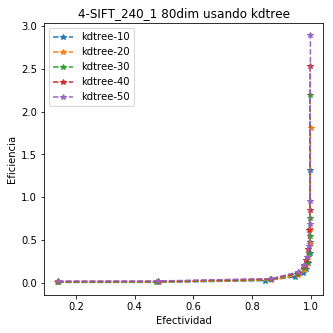

MEJOR KDTREE
Nombre: 4-SIFT_240_1 80dim
Tipo: kdtree-10
Tiempo de construcción: 0.6610946655273438
Tiempo de búsqueda: 1.8816030025482178
Efeciencia: 0.12578240427870585
Efectividad: 0.9565338147479516
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.0075378861682139295


MEJOR KMEANS TREE
Nombre: 4-SIFT_240_1 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0260040760040283
Tiempo de búsqueda: 0.7606422901153564
Efeciencia: 0.05084788281831709
Efectividad: 0.9511179002916261
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004974966859004712


MEJOR CONFIGURACION
Nombre: 4-SIFT_240_1 80dim
Tipo: kmtree-50
Tiempo de construcción: 2.0260040760040283
Tiempo de búsqueda: 0.7606422901153564
Efeciencia: 0.05084788281831709
Efectividad: 0.9511179002916261
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.004974966859004712


In [358]:
best_configurations.append(show('4-SIFT_240_1 80dim', kdtrees_6_80, kmtrees_6_80, 5, 5))

# Análisis de 4-SURF_240_1

Se analizará 4-SURF_240_1 al aplicarle diferentes PCA.

In [9]:
dataset_r_7_30 = load_file(carpeta_descriptores+"4-SURF_240_1/PCA-30dim-98.3var/R-35798_30_4F.bin", 30)
dataset_q_7_30 = load_file(carpeta_descriptores+"4-SURF_240_1/PCA-30dim-98.3var/Q-7201_30_4F.bin", 30)

dataset_r_7_64 = load_file(carpeta_descriptores+"4-SURF_240_1/PCA-64dim-100var/R-35798_64_4F.bin", 64)
dataset_q_7_64 = load_file(carpeta_descriptores+"4-SURF_240_1/PCA-64dim-100var/Q-7201_64_4F.bin", 64)

In [360]:
#Busqueda lineal 30dim
lineal_7_30 = LinearResult()
lineal_7_30.name = "4-SURF_240_1"
lineal_7_30.type = "LINEAL 30"

t0 = time.time()
flann.build_index(dataset_r_7_30, algorithm="linear")
lineal_7_30.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_7_30, num_neighbors=1, cores=1)
lineal_7_30.search_time = time.time() - t0

lineal_7_30.results_search = results_search
lineal_7_30.dists_search = dists_search

In [361]:
#Busqueda lineal 144dim
lineal_7_64 = LinearResult()
lineal_7_64.name = "4-SURF_240_1"
lineal_7_64.type = "LINEAL 64"

t0 = time.time()
flann.build_index(dataset_r_7_64, algorithm="linear")
lineal_7_64.construction_time = time.time() - t0

t0 = time.time()
results_search, dists_search = flann.nn_index(dataset_q_7_64, num_neighbors=1, cores=1)
lineal_7_64.search_time = time.time() - t0

lineal_7_64.results_search = results_search
lineal_7_64.dists_search = dists_search

## Usando Randomized KD-Tree
### Dimension 30

In [362]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_7_30 = get_kdtree_result("4-SURF_240_1 30dim", "kdtree-10", 10, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [363]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_7_30 = get_kdtree_result("4-SURF_240_1 30dim", "kdtree-20", 20, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [364]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_7_30 = get_kdtree_result("4-SURF_240_1 30dim", "kdtree-30", 30, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [365]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_7_30 = get_kdtree_result("4-SURF_240_1 30dim", "kdtree-40", 40, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [366]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_7_30 = get_kdtree_result("4-SURF_240_1 30dim", "kdtree-50", 50, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [367]:
kdtrees_7_30 = [kdtree_10_7_30, kdtree_20_7_30, kdtree_30_7_30, kdtree_40_7_30, kdtree_50_7_30]

### Dimension 64

In [368]:
#Construir y buscar con un kdtree con 10 arboles, con diferentes checks
kdtree_10_7_64 = get_kdtree_result("4-SURF_240_1 64dim", "kdtree-10", 10, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [369]:
#Construir y buscar con un kdtree con 20 arboles, con diferentes checks
kdtree_20_7_64 = get_kdtree_result("4-SURF_240_1 64dim", "kdtree-20", 20, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [370]:
#Construir y buscar con un kdtree con 30 arboles, con diferentes checks
kdtree_30_7_64 = get_kdtree_result("4-SURF_240_1 64dim", "kdtree-30", 30, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [371]:
#Construir y buscar con un kdtree con 40 arboles, con diferentes checks
kdtree_40_7_64 = get_kdtree_result("4-SURF_240_1 64dim", "kdtree-40", 40, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [372]:
#Construir y buscar con un kdtree con 50 arboles, con diferentes checks
kdtree_50_7_64 = get_kdtree_result("4-SURF_240_1 64dim", "kdtree-50", 50, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [373]:
kdtrees_7_64 = [kdtree_10_7_64, kdtree_20_7_64, kdtree_30_7_64, kdtree_40_7_64, kdtree_50_7_64]

## Usando K-Means Tree
### Dimensión 30

In [374]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_7_30 = get_kmeans_result("4-SURF_240_1 30dim", "kmtree-10", 10, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [375]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_7_30 = get_kmeans_result("4-SURF_240_1 30dim", "kmtree-20", 20, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [376]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_7_30 = get_kmeans_result("4-SURF_240_1 30dim", "kmtree-30", 30, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [377]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_7_30 = get_kmeans_result("4-SURF_240_1 30dim", "kmtree-40", 40, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [378]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_7_30 = get_kmeans_result("4-SURF_240_1 30dim", "kmtree-50", 50, dataset_r_7_30, dataset_q_7_30, lineal_7_30)

In [379]:
kmtrees_7_30 = [kmtree_10_7_30, kmtree_20_7_30, kmtree_30_7_30, kmtree_40_7_30, kmtree_50_7_30]

### Dimensión 64

In [380]:
#Construir y buscar con un K-Means Tree con 10 branches, con diferentes checks
kmtree_10_7_64 = get_kmeans_result("4-SURF_240_1 64dim", "kmtree-10", 10, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [381]:
#Construir y buscar con un K-Means Tree con 20 branches, con diferentes checks
kmtree_20_7_64 = get_kmeans_result("4-SURF_240_1 64dim", "kmtree-20", 20, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [382]:
#Construir y buscar con un K-Means Tree con 30 branches, con diferentes checks
kmtree_30_7_64 = get_kmeans_result("4-SURF_240_1 64dim", "kmtree-30", 30, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [383]:
#Construir y buscar con un K-Means Tree con 40 branches, con diferentes checks
kmtree_40_7_64 = get_kmeans_result("4-SURF_240_1 64dim", "kmtree-40", 40, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [384]:
#Construir y buscar con un K-Means Tree con 50 branches, con diferentes checks
kmtree_50_7_64 = get_kmeans_result("4-SURF_240_1 64dim", "kmtree-50", 50, dataset_r_7_64, dataset_q_7_64, lineal_7_64)

In [385]:
kmtrees_7_64 = [kmtree_10_7_64, kmtree_20_7_64, kmtree_30_7_64, kmtree_40_7_64, kmtree_50_7_64]

## Gráficos y resultados
### Dimensión 30

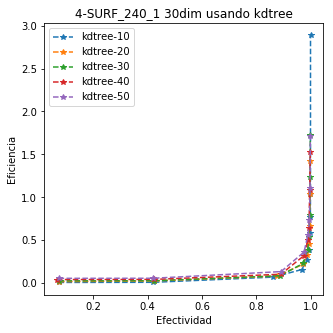

MEJOR KDTREE
Nombre: 4-SURF_240_1 30dim
Tipo: kdtree-30
Tiempo de construcción: 1.0388891696929932
Tiempo de búsqueda: 0.9403021335601807
Efeciencia: 0.13542139297356642
Efectividad: 0.8912651020691571
Cantidad de checks: 100
Con una distancia euclideana al óptimo de: 0.020254871571164547


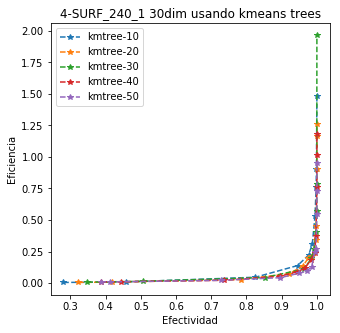

MEJOR KMEANS TREE
Nombre: 4-SURF_240_1 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.9028563499450684
Tiempo de búsqueda: 0.5467488765716553
Efeciencia: 0.0787424848072017
Efectividad: 0.9500069434800722
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.008699684613817087


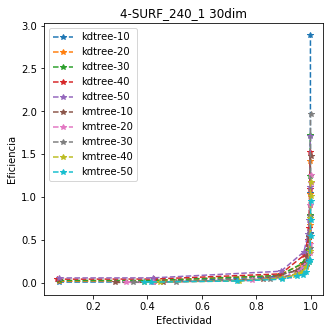

MEJOR CONFIGURACION
Nombre: 4-SURF_240_1 30dim
Tipo: kmtree-50
Tiempo de construcción: 0.9028563499450684
Tiempo de búsqueda: 0.5467488765716553
Efeciencia: 0.0787424848072017
Efectividad: 0.9500069434800722
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.008699684613817087


In [386]:
best_configurations.append(show('4-SURF_240_1 30dim', kdtrees_7_30, kmtrees_7_30, 5, 5))

### Dimensión 64

MEJOR KDTREE
Nombre: 4-SURF_240_1 64dim
Tipo: kdtree-10
Tiempo de construcción: 0.6804273128509521
Tiempo de búsqueda: 2.6452155113220215
Efeciencia: 0.2053792596444848
Efectividad: 0.9727815581169282
Cantidad de checks: 300
Con una distancia euclideana al óptimo de: 0.009260563644877042


MEJOR KMEANS TREE
Nombre: 4-SURF_240_1 64dim
Tipo: kmtree-50
Tiempo de construcción: 1.7708086967468262
Tiempo de búsqueda: 0.8047034740447998
Efeciencia: 0.062478750265427895
Efectividad: 0.9380641577558673
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.007739642789219804


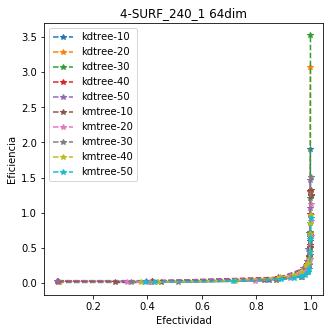

MEJOR CONFIGURACION
Nombre: 4-SURF_240_1 64dim
Tipo: kmtree-50
Tiempo de construcción: 1.7708086967468262
Tiempo de búsqueda: 0.8047034740447998
Efeciencia: 0.062478750265427895
Efectividad: 0.9380641577558673
Cantidad de checks: 500
Con una distancia euclideana al óptimo de: 0.007739642789219804


In [387]:
best_configurations.append(show('4-SURF_240_1 64dim', kdtrees_7_64, kmtrees_7_64, 5, 5))

In [14]:
dataset_r_1 = load_file(carpeta_descriptores+"1-IMGRAY_16X9/R-35798_144_4F.bin", 144)
dataset_r_2 = load_file(carpeta_descriptores+"1-IMGRAY_16X9_AVG/R-35798_144_4F.bin", 144)
dataset_r_3 = load_file(carpeta_descriptores+"2-MEL_16000_80_64_32/R-35798_80_4F.bin", 80)
dataset_r_4 = load_file(carpeta_descriptores+"3-ALEXNET_FC7/R-35798_4096_4F.bin", 4096)
dataset_r_5 = load_file(carpeta_descriptores+"3-VGG_FC7/R-35798_4096_4F.bin", 4096)
dataset_r_6 = load_file(carpeta_descriptores+"4-SIFT_240_1/R-35798_128_4F.bin", 128)
dataset_r_7 = load_file(carpeta_descriptores+"4-SURF_240_1/R-35798_64_4F.bin", 64)

print("Distancia promedio 1-IMGRAY_16X9: " + str(mean_of_means(dataset_r_1)))
print("Distancia promedio 1-IMGRAY_16X9 PCA-30dim-82.7var: " + str(mean_of_means(dataset_r_1_30)))
print("Distancia promedio 1-IMGRAY_16X9 PCA-80dim-95.1var: " + str(mean_of_means(dataset_r_1_80)))
print("Distancia promedio 1-IMGRAY_16X9 PCA-144dim-100var: " + str(mean_of_means(dataset_r_1_144)))

print("Distancia promedio 1-IMGRAY_16X9_AVG: " + str(mean_of_means(dataset_r_2)))
print("Distancia promedio 1-IMGRAY_16X9_AVG PCA-30dim-82.7var: " + str(mean_of_means(dataset_r_2_30)))
print("Distancia promedio 1-IMGRAY_16X9_AVG PCA-80dim-95.1var: " + str(mean_of_means(dataset_r_2_80)))
print("Distancia promedio 1-IMGRAY_16X9_AVG PCA-144dim-100var: " + str(mean_of_means(dataset_r_2_144)))

print("Distancia promedio 2-MEL_16000_80_64_32: " + str(mean_of_means(dataset_r_3)))
print("Distancia promedio 2-MEL_16000_80_64_32 PCA-30dim-92.2var: " + str(mean_of_means(dataset_r_3_30)))
print("Distancia promedio 2-MEL_16000_80_64_32 PCA-80dim-100var: " + str(mean_of_means(dataset_r_3_80)))

print("Distancia promedio 3-ALEXNET_FC7: " + str(mean_of_means(dataset_r_4)))
print("Distancia promedio 3-ALEXNET_FC7 PCA-30dim-48.4var: " + str(mean_of_means(dataset_r_4_30)))
print("Distancia promedio 3-ALEXNET_FC7 PCA-80dim-63.5var: " + str(mean_of_means(dataset_r_4_80)))
print("Distancia promedio 3-ALEXNET_FC7 PCA-144dim-71.2var: " + str(mean_of_means(dataset_r_4_144)))
print("Distancia promedio 3-ALEXNET_FC7/PCA-400dim-82.9var: " + str(mean_of_means(dataset_r_4_400)))

print("Distancia promedio 3-VGG_FC7: " + str(mean_of_means(dataset_r_5)))
print("Distancia promedio 3-VGG_FC7 PCA-30dim-58.1var: " + str(mean_of_means(dataset_r_5_30)))
print("Distancia promedio 3-VGG_FC7 PCA-80dim-74.2var: " + str(mean_of_means(dataset_r_5_80)))
print("Distancia promedio 3-VGG_FC7 PCA-144dim-81.2var: " + str(mean_of_means(dataset_r_5_144)))
print("Distancia promedio 3-VGG_FC7 PCA-400dim-89.6var: " + str(mean_of_means(dataset_r_5_400)))

print("Distancia promedio 4-SIFT_240_1: " + str(mean_of_means(dataset_r_6)))
print("Distancia promedio 4-SIFT_240_1 PCA-30dim-82.2var: " + str(mean_of_means(dataset_r_6_30)))
print("Distancia promedio 4-SIFT_240_1 PCA-64dim-94.2var: " + str(mean_of_means(dataset_r_6_64)))
print("Distancia promedio 4-SIFT_240_1/PCA-80dim-96.7var: " + str(mean_of_means(dataset_r_6_80)))

print("Distancia promedio 4-SURF_240_1 PCA-30dim-98.3var: " + str(mean_of_means(dataset_r_7)))
print("Distancia promedio 4-SURF_240_1 PCA-30dim-98.3var: " + str(mean_of_means(dataset_r_7_30)))
print("Distancia promedio 4-SURF_240_1 PCA-64dim-100var: " + str(mean_of_means(dataset_r_7_64)))

Distancia promedio 1-IMGRAY_16X9: 1022.8144363590342
Distancia promedio 1-IMGRAY_16X9 PCA-30dim-82.7var: 916.44364436242
Distancia promedio 1-IMGRAY_16X9 PCA-80dim-95.1var: 994.1310603779416
Distancia promedio 1-IMGRAY_16X9 PCA-144dim-100var: 1022.2823583282798
Distancia promedio 1-IMGRAY_16X9_AVG: 975.6736209866044
Distancia promedio 1-IMGRAY_16X9_AVG PCA-30dim-82.7var: 889.0938720970839
Distancia promedio 1-IMGRAY_16X9_AVG PCA-80dim-95.1var: 953.5423116629072
Distancia promedio 1-IMGRAY_16X9_AVG PCA-144dim-100var: 975.423237243148
Distancia promedio 2-MEL_16000_80_64_32: 0.09977250165909979
Distancia promedio 2-MEL_16000_80_64_32 PCA-30dim-92.2var: 0.09555170753567573
Distancia promedio 2-MEL_16000_80_64_32 PCA-80dim-100var: 0.09980107669379452
Distancia promedio 3-ALEXNET_FC7: 78.58539579911736
Distancia promedio 3-ALEXNET_FC7 PCA-30dim-48.4var: 53.987918840903326
Distancia promedio 3-ALEXNET_FC7 PCA-80dim-63.5var: 62.27417016380874
Distancia promedio 3-ALEXNET_FC7 PCA-144dim-71.2va

## Resultados

## Tabla 1: Resultados de cada "mejor configuración" para el descriptor
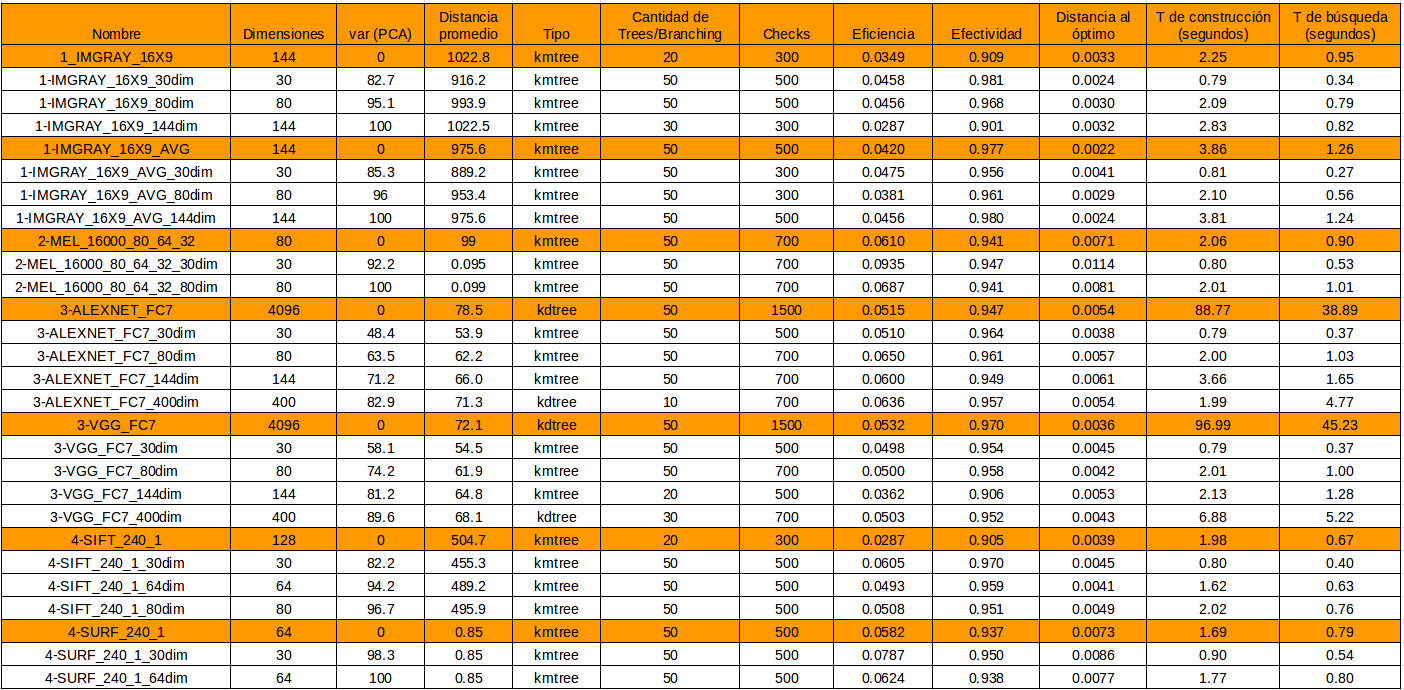

*Las filas naranjas corresponden a los desciptores sin PCA.

*Tabla adjunta en la tarea, por si se quieren hacer pruebas ordenando según alguna columna.

# Conclusiones

Si ordenamos la tabla anterior por cantidad de dimensiones de los descriptores, se puede observar que a medida que crecen las dimensionalidades, suben los tiempos de construcción de los índices junto con el tiempo de búsqueda en estos mismos. Sin embargo, en eficiencia y efectividad, no necesariamente crece o decrece, por lo que no se puede predecir una relación directa entre dimensionalidad, eficiencia y efectividad. Un dato interesante es que los cuatro descriptores con mayor dimensionalidad (3-ALEXNET_FC7_400dim, 3-VGG_FC7_400dim, 3-ALEXNET_FC7_4096dim, 3-VGG_FC7_4096dim) son los únicos en donde el índice que da mejor rendimiento son kd-trees. Por lo tanto, se podría concluir que para alta dimensionalidad, kdtree funciona mejor que kmtree.

Si ordenamos la tabla anterior por secciones (por cada descriptor) según la varianza del PCA, se observa que hay algunos que logran mejor eficiencia y eficacia con menos varianza y otros con más, pero no hay una regla general que se cumpla para todos, por lo que tampoco se puede establecer una relación directa entre dimensionalidad, eficiencia y efectividad.

Si ordenamos la tabla anterior según la distancia entre vectores, nuevamente no se observa un patrón determinado, ni en tiempos ni en desempeño.

Por lo tanto, se puede concluir que para cada problema deben calcularse todas las posibilidades, ya que no existe forma de saber a priori que conviene tener en cuanto a dimensionalidad, varianza o distancia entre vectores. Para este caso, las mejores distancias al óptimo fueron 1-IMGRAY_16X9_AVG, 1-IMGRAY_16X9_30dim y 1-IMGRAY_16X9_AVG_144dim, los cuales virtualmente tienen la misma distancia de 0.023.